# Practical Application III: Comparing Classifiers



### Dataset

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

The dataset was collected from a Portuguese bank that conducted marketing campaigns through its contact center, primarily using telephone interactions with human agents. Occasionally, the bank also leveraged online banking as an auxiliary channel to provide targeted clients with specific information. These campaigns were managed in an integrated manner, and the results were compiled across all channels.

The data spans 17 campaigns conducted between May 2008 and November 2010, totaling 79,354 contacts. The campaigns promoted a long-term deposit product with attractive interest rates. A wide range of attributes was recorded for each contact, and the outcome of whether the campaign was successful (i.e., if the client subscribed) was tracked. Overall, 6,499 successes were recorded, resulting in an 8% success rate.

### Problem 2: Read in the Data

In [6]:
!pip install -U threadpoolctl
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
import plotly.express as px
import warnings
import seaborn as sns
import time

from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from imblearn.over_sampling import SMOTE, BorderlineSMOTE

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier, export_text, plot_tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.impute import KNNImputer
from sklearn.feature_selection import SelectFromModel
from sklearn import set_config
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score, ConfusionMatrixDisplay, precision_recall_curve, roc_auc_score, roc_curve,RocCurveDisplay
from sklearn.metrics import auc as skl_auc

import warnings

# Suppress all warnings globally
warnings.filterwarnings("ignore")

set_config("figure")
#Dispaly all columns
pd.set_option('display.max_columns', None)

In [7]:
df = pd.read_csv('data/bank-additional-full.csv', sep = ';')

In [8]:
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Problem 3: Understanding the Features

```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

In [11]:
# Display key statistics of category 'age'
df['age'].value_counts()

age
31    1947
32    1846
33    1833
36    1780
35    1759
      ... 
89       2
91       2
94       1
87       1
95       1
Name: count, Length: 78, dtype: int64

Text(0, 0.5, 'Count')

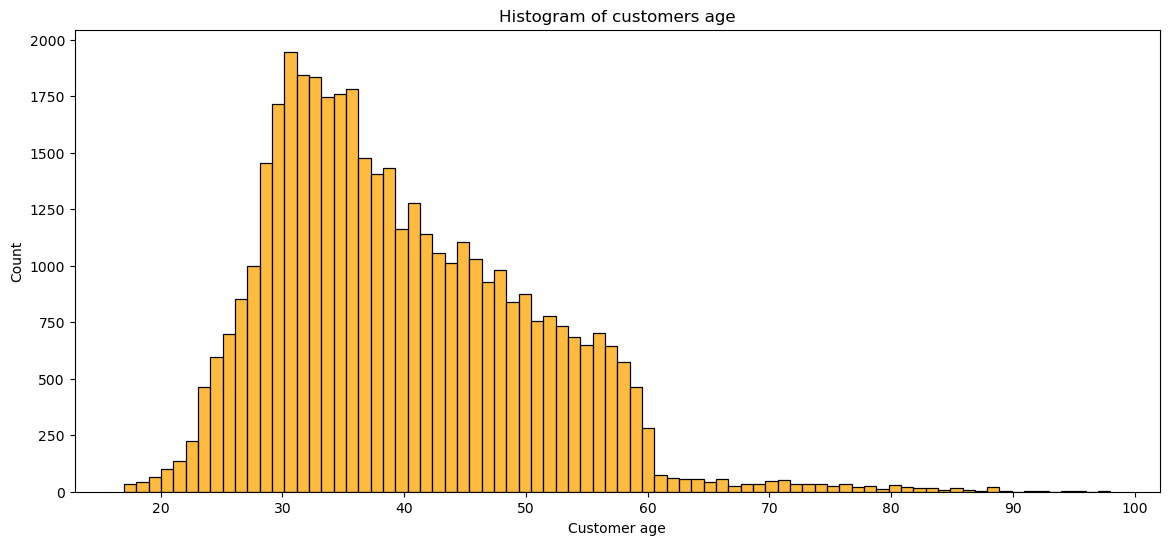

In [12]:
# Display key statistics of category 'age'
plt.figure(figsize=(14, 6))
sns.histplot(df, x='age',bins=80, color='orange')
#plt.yscale('log')
plt.title('Histogram of customers age')
plt.xlabel('Customer age')
plt.ylabel('Count')

In [13]:
# Display key statistics of category 'job'
df['job'].value_counts()

job
admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: count, dtype: int64

In [14]:
# Display key statistics of category 'marital'
df['marital'].value_counts()

marital
married     24928
single      11568
divorced     4612
unknown        80
Name: count, dtype: int64

In [15]:
# Display key statistics of category 'education'
df['education'].value_counts()

education
university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: count, dtype: int64

In [16]:
# Display key statistics of category 'default'
df['default'].value_counts()

default
no         32588
unknown     8597
yes            3
Name: count, dtype: int64

In [17]:
# Display key statistics of category 'housing'
df['housing'].value_counts()

housing
yes        21576
no         18622
unknown      990
Name: count, dtype: int64

In [18]:
# Display key statistics of category 'loan'
df['loan'].value_counts()

loan
no         33950
yes         6248
unknown      990
Name: count, dtype: int64

In [19]:
# Display key statistics of category 'contact'
df['contact'].value_counts()

contact
cellular     26144
telephone    15044
Name: count, dtype: int64

In [20]:
# Display key statistics of category 'month'
df['month'].value_counts()

month
may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: count, dtype: int64

In [21]:
# Display key statistics of category 'day_of_week'
df['day_of_week'].value_counts()

day_of_week
thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: count, dtype: int64

Text(0, 0.5, 'Log10 Count')

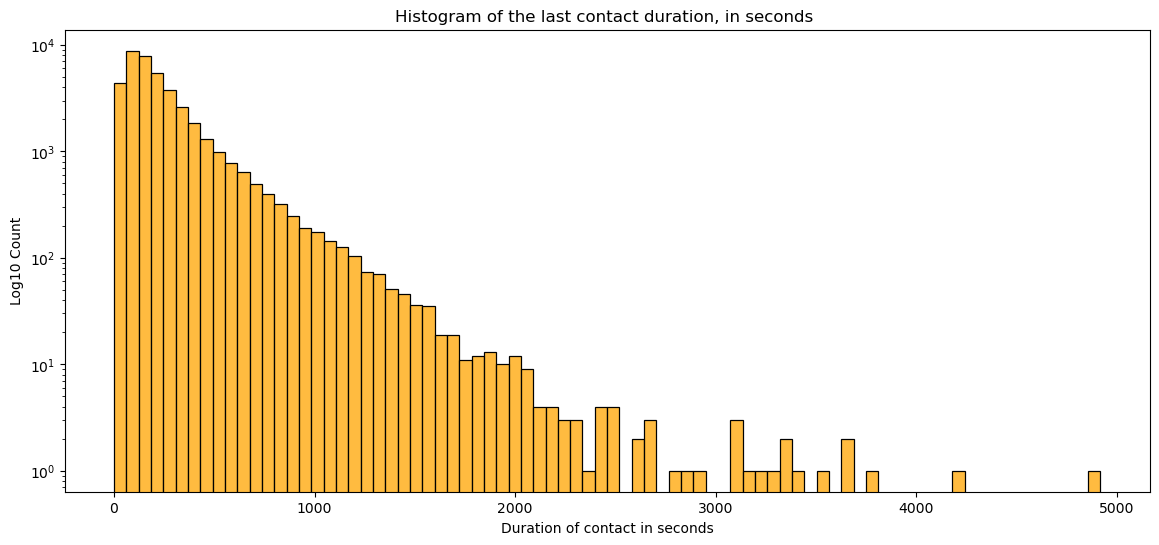

In [22]:
# Display key statistics of category 'duration'
plt.figure(figsize=(14, 6))
sns.histplot(df, x='duration',bins=80, color='orange')
plt.yscale('log')
#plt.xscale('log')
plt.title('Histogram of the last contact duration, in seconds ')
plt.xlabel('Duration of contact in seconds')
plt.ylabel('Log10 Count')

Text(0, 0.5, 'Log10 Count')

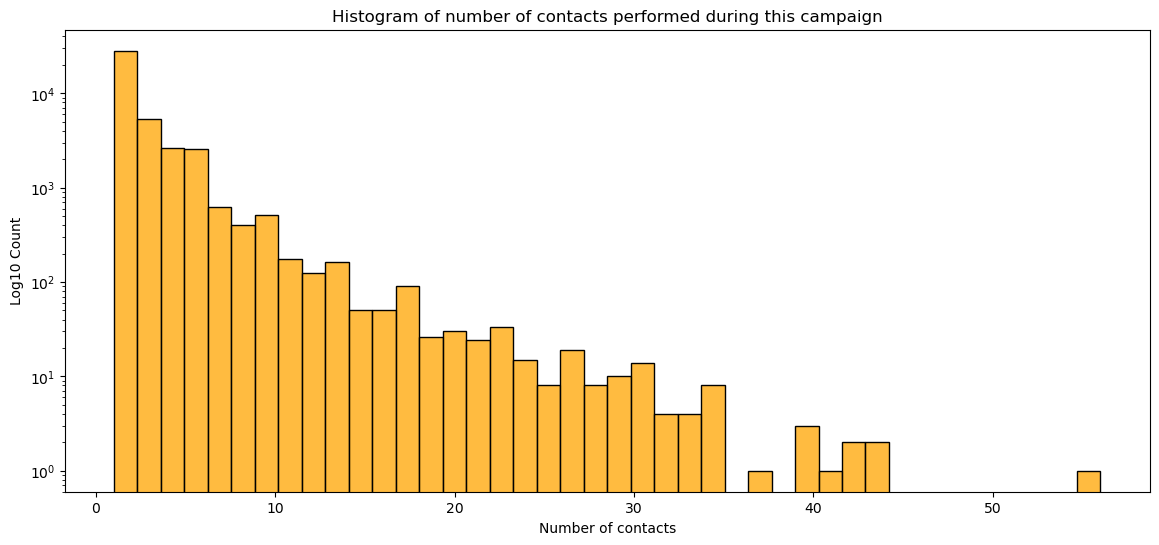

In [23]:
# Display key statistics of category 'campaign'
plt.figure(figsize=(14, 6))
sns.histplot(df, x='campaign',bins=42, color='orange')
plt.yscale('log')
#plt.xscale('log')
plt.title('Histogram of number of contacts performed during this campaign')
plt.xlabel('Number of contacts')
plt.ylabel('Log10 Count')

Text(0, 0.5, 'Log10 count')

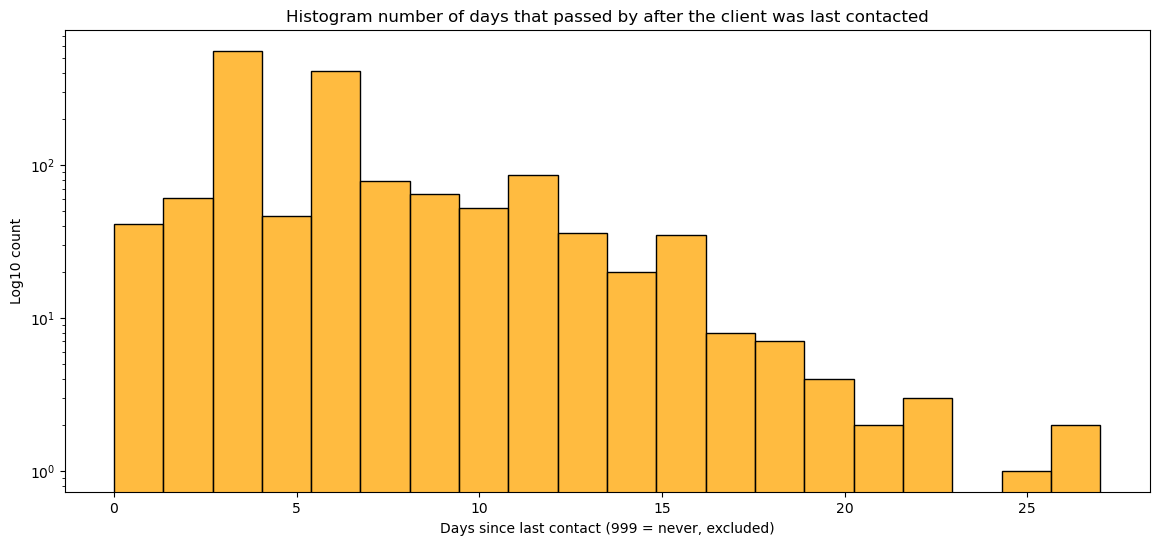

In [24]:
# Display key statistics of category 'pdays'
plt.figure(figsize=(14, 6))
sns.histplot(df[df['pdays']<30], x='pdays',bins=20, color='orange')
plt.yscale('log')
#plt.xscale('log')
plt.title('Histogram number of days that passed by after the client was last contacted')
plt.xlabel('Days since last contact (999 = never, excluded)')
plt.ylabel('Log10 count')

In [25]:
# Display key statistics of category 'pdays'
df['pdays'].value_counts()

pdays
999    39673
3        439
6        412
4        118
9         64
2         61
7         60
12        58
10        52
5         46
13        36
11        28
1         26
15        24
14        20
8         18
0         15
16        11
17         8
18         7
22         3
19         3
21         2
25         1
26         1
27         1
20         1
Name: count, dtype: int64

In [26]:
# Display key statistics of category 'previous'
df['previous'].value_counts()

previous
0    35563
1     4561
2      754
3      216
4       70
5       18
6        5
7        1
Name: count, dtype: int64

In [27]:
# Display key statistics of category 'poutcome'
df['poutcome'].value_counts()

poutcome
nonexistent    35563
failure         4252
success         1373
Name: count, dtype: int64

In [28]:
# Display key statistics of category 'emp.var.rate'
df['emp.var.rate'].value_counts()

emp.var.rate
 1.4    16234
-1.8     9184
 1.1     7763
-0.1     3683
-2.9     1663
-3.4     1071
-1.7      773
-1.1      635
-3.0      172
-0.2       10
Name: count, dtype: int64

Text(0, 0.5, 'Count')

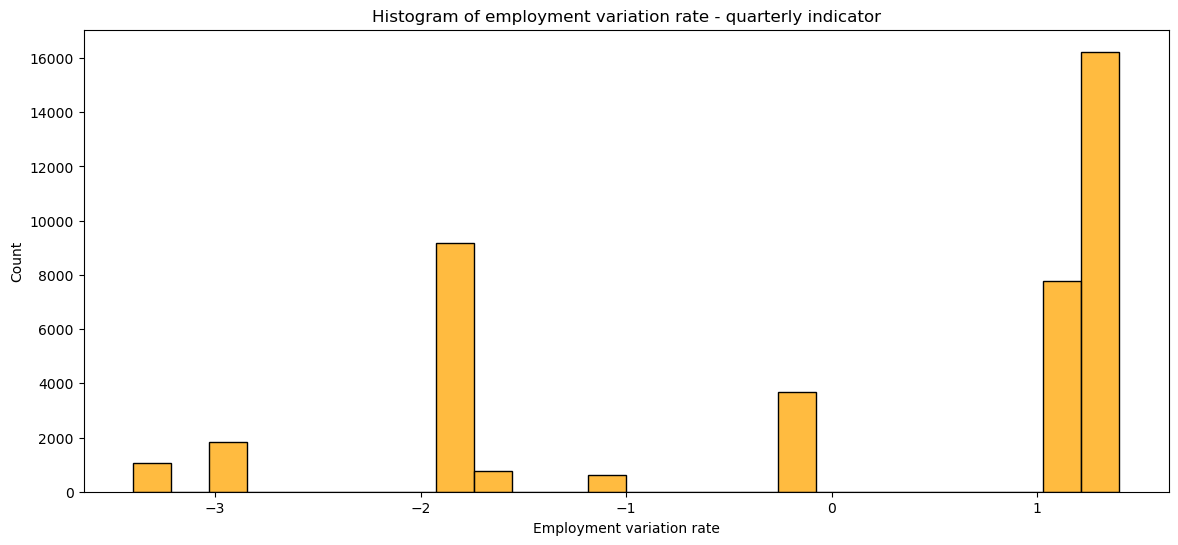

In [29]:
# Display key statistics of category 'emp.var.rate'
plt.figure(figsize=(14, 6))
sns.histplot(df, x='emp.var.rate', color='orange')
#plt.yscale('log')
#plt.xscale('log')
plt.title('Histogram of employment variation rate - quarterly indicator')
plt.xlabel('Employment variation rate')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

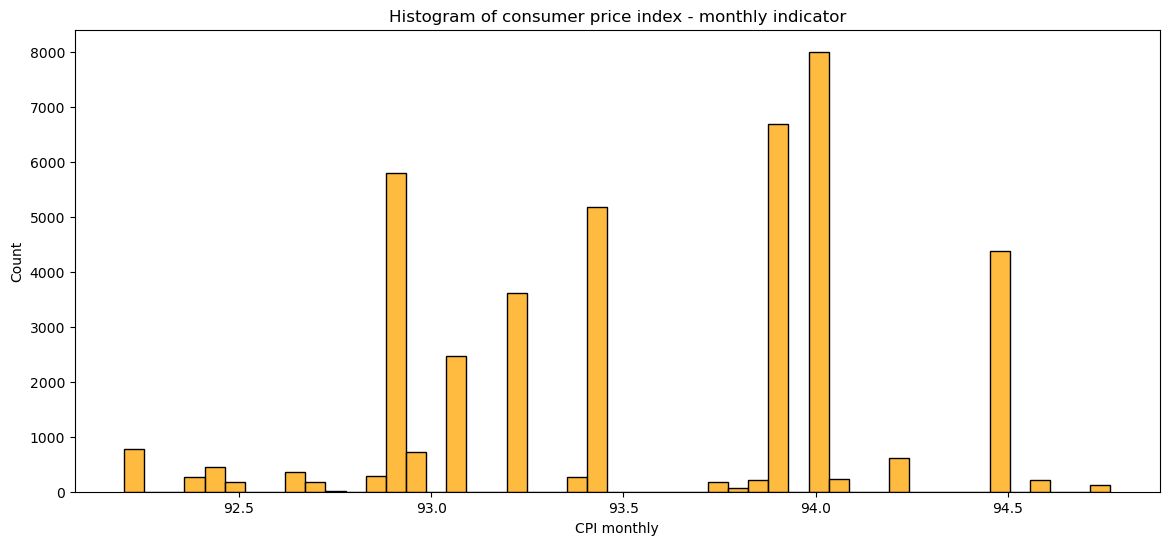

In [30]:
# Display key statistics of category 'cons.price.idx'
plt.figure(figsize=(14, 6))
sns.histplot(df, x='cons.price.idx', color='orange')
#plt.yscale('log')
#plt.xscale('log')
plt.title('Histogram of consumer price index - monthly indicator')
plt.xlabel('CPI monthly')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

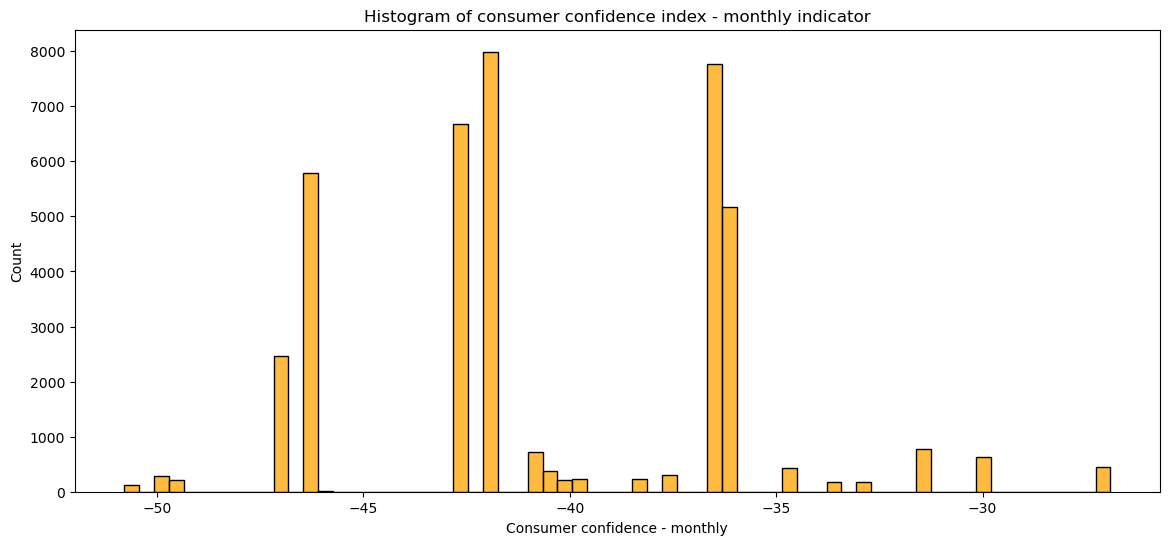

In [31]:
# Display key statistics of category 'cons.conf.idx'
plt.figure(figsize=(14, 6))
sns.histplot(df, x='cons.conf.idx', color='orange')
#plt.yscale('log')
#plt.xscale('log')
plt.title('Histogram of consumer confidence index - monthly indicator')
plt.xlabel('Consumer confidence - monthly')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

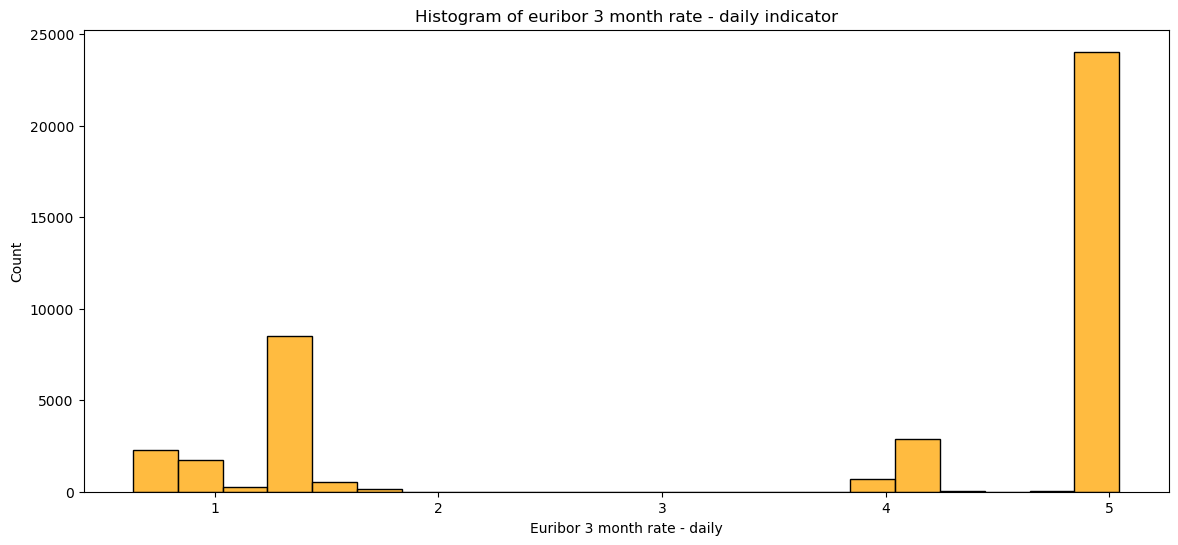

In [32]:
# Display key statistics of category 'euribor3m'
plt.figure(figsize=(14, 6))
sns.histplot(df, x='euribor3m', color='orange')
#plt.yscale('log')
#plt.xscale('log')
plt.title('Histogram of euribor 3 month rate - daily indicator')
plt.xlabel('Euribor 3 month rate - daily')
plt.ylabel('Count')

Text(0, 0.5, 'Count')

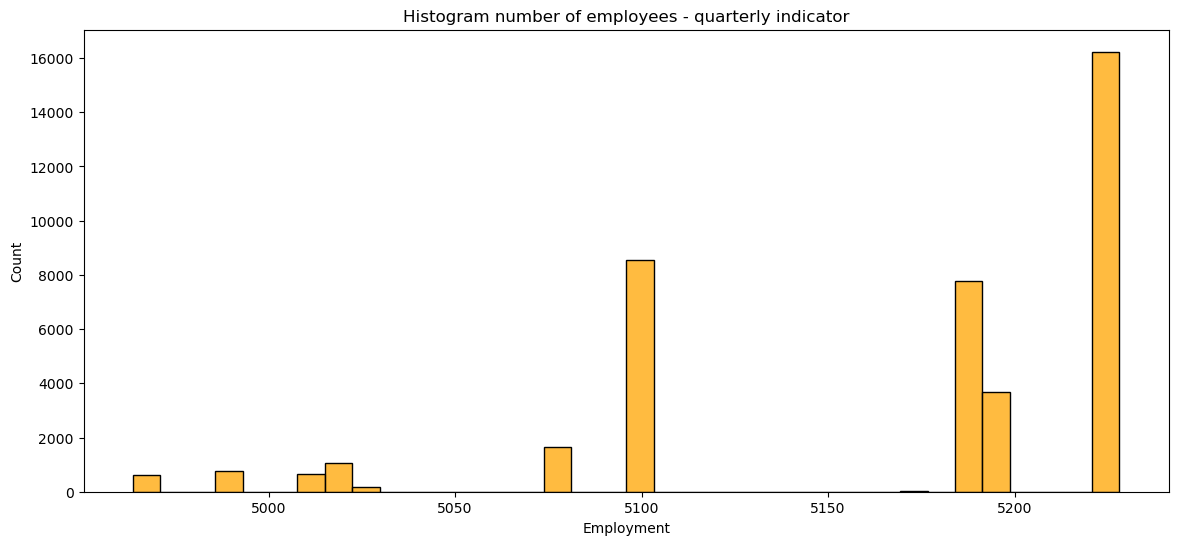

In [33]:
# Display key statistics of category 'nr.employed'
plt.figure(figsize=(14, 6))
sns.histplot(df, x='nr.employed', color='orange')
#plt.yscale('log')
#plt.xscale('log')
plt.title('Histogram number of employees - quarterly indicator')
plt.xlabel('Employment')
plt.ylabel('Count')

##### Target category is unbalanced, with ~12% of entries saying 'yes'.

In [34]:
# Display key statistics of category 'y' - target category (has the client subscribed a term deposit?)
df['y'].value_counts()

y
no     36548
yes     4640
Name: count, dtype: int64

### Problem 4: Business Objective

##### Business objective is to improve the efficiency of bank direct marketing campaigns. Specifically, the goal is to reduce the number of customer contacts while maintaining or increasing the number of successful long-term deposit subscriptions. By building predictive models using data mining, the bank can identify key factors that influence customer responses, enabling more targeted and resource-efficient campaigns. This will ultimately enhance marketing performance, reduce costs, and optimize resource allocation.

### Problem 5: Engineering Features

    1. Removed feature 'default', it has only 3 positive entries, making it statistically unreliable whle also having high proportion of unnown data
    2. Drop unknown labels for features: 'loan','housing','education','marital','job' - in total 2943 entries were removed leaving 38245 entries
    3. One hot encoded categorical data.
    4. Created synthetic data to balance target using Synthetic Minority Over-sampling Technique (SMOTE)

In [39]:
#Drop columns 'duration' and 'default' 
df_1 = df.drop(columns=['default'])
#Remove any entry that contains word 'unknown'
df_cleaned = df_1[~df_1.isin(['unknown']).any(axis=1)]
#count how many entries were removed 
print('Removed ',len(df_1)-len(df_cleaned),' entries containing unkown labels')

Removed  2943  entries containing unkown labels


In [40]:
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38245 entries, 0 to 41187
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             38245 non-null  int64  
 1   job             38245 non-null  object 
 2   marital         38245 non-null  object 
 3   education       38245 non-null  object 
 4   housing         38245 non-null  object 
 5   loan            38245 non-null  object 
 6   contact         38245 non-null  object 
 7   month           38245 non-null  object 
 8   day_of_week     38245 non-null  object 
 9   duration        38245 non-null  int64  
 10  campaign        38245 non-null  int64  
 11  pdays           38245 non-null  int64  
 12  previous        38245 non-null  int64  
 13  poutcome        38245 non-null  object 
 14  emp.var.rate    38245 non-null  float64
 15  cons.price.idx  38245 non-null  float64
 16  cons.conf.idx   38245 non-null  float64
 17  euribor3m       38245 non-null  floa

In [41]:
#List of columns with object dtype
object_columns = df_cleaned.select_dtypes(include=['object']).columns.tolist()
#One hot encode categorical features, set the data type to int and dropped first label of categorical data.
#df_with_dummies = pd.get_dummies(df_cleaned, columns=['y'], dtype=int, drop_first=True)
df_with_dummies = pd.get_dummies(df_cleaned, columns=object_columns, dtype=int,drop_first=False).drop(columns='y_no')
df_with_dummies.info()

<class 'pandas.core.frame.DataFrame'>
Index: 38245 entries, 0 to 41187
Data columns (total 56 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   age                            38245 non-null  int64  
 1   duration                       38245 non-null  int64  
 2   campaign                       38245 non-null  int64  
 3   pdays                          38245 non-null  int64  
 4   previous                       38245 non-null  int64  
 5   emp.var.rate                   38245 non-null  float64
 6   cons.price.idx                 38245 non-null  float64
 7   cons.conf.idx                  38245 non-null  float64
 8   euribor3m                      38245 non-null  float64
 9   nr.employed                    38245 non-null  float64
 10  job_admin.                     38245 non-null  int32  
 11  job_blue-collar                38245 non-null  int32  
 12  job_entrepreneur               38245 non-null  int3

In [42]:
df_with_dummies

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_divorced,marital_married,marital_single,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,housing_no,housing_yes,loan_no,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success,y_yes
0,56,261,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
1,57,149,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
2,37,226,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
3,40,151,1,999,0,1.1,93.994,-36.4,4.857,5191.0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
4,56,307,1,999,0,1.1,93.994,-36.4,4.857,5191.0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41183,73,334,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1
41184,46,383,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
41185,56,189,2,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0
41186,44,442,1,999,0,-1.1,94.767,-50.8,1.028,4963.6,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,1,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1


### Problem 6: Train/Test Split

In [44]:
#Spilt Data between Train and test set
X_train, X_test, y_train, y_test = train_test_split(df_with_dummies.drop(columns='y_yes'), df_with_dummies['y_yes'], shuffle=True, test_size=0.3, random_state = 34)

In [45]:
# Count target balance
y_train.value_counts()

y_yes
0    23858
1     2913
Name: count, dtype: int64

#### Since target category is unbalanced, I have created training set with Balanced target using SMOTE. This dataset will be later compared to unbalanced one to see whether it improves quality of predictions.

In [47]:
#Rebalance data using SMOTE
smote = SMOTE()
X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [48]:
#Check target balance after SMOTE rebalance
y_resampled.value_counts()

y_yes
1    23858
0    23858
Name: count, dtype: int64

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

### Dummy classifier with umbalanced data

Time needed to complete: 0.0 second
Training Accuracy:  0.89
Accuracy:  0.88
Recall:  0.0
Precision:  0.0
ROC AUC:  0.5


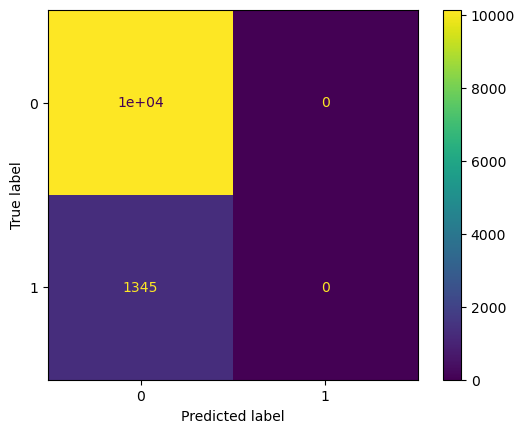

In [51]:
#Define Dummy Classifer pipeline, and measure time necessary to train
start_time = time.time()
dummy_pipe = Pipeline([('scaler',StandardScaler()),
                       ('dummy',DummyClassifier())]).fit(X_train,y_train)
end_time = time.time()

#How much time did it take
dummy_execution_time = end_time - start_time  # Calculate the elapsed time
print('Time needed to complete:',round(dummy_execution_time,1),'second')

#Caluculate fidelity scores
preds = dummy_pipe.predict(X_test)
dummy_acc_train = dummy_pipe.score(X_train,y_train)
dummy_acc = dummy_pipe.score(X_test,y_test)
dummy_precision = precision_score(y_test, preds, pos_label=1)
dummy_recall = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = dummy_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
dummy_roc_auc_value = skl_auc(fpr, tpr)

#Print results
print('Training Accuracy: ',round(dummy_acc_train,2))
print('Accuracy: ',round(dummy_acc,2))
print('Recall: ',round(dummy_recall,2))
print('Precision: ',round(dummy_precision,2))
print('ROC AUC: ',round(dummy_roc_auc_value,2))

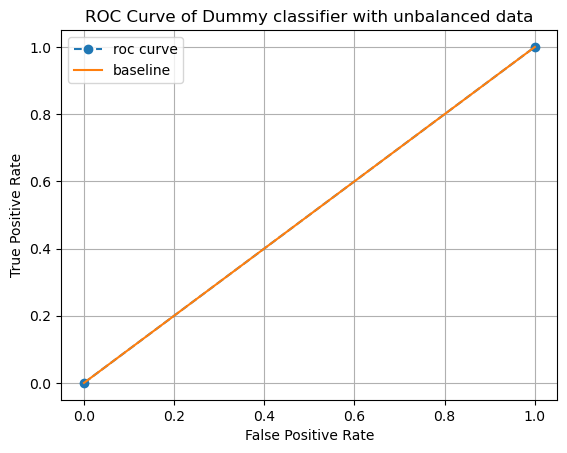

In [52]:
# ROC Curve of Dummy classifier with unbalanced data
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve of Dummy classifier with unbalanced data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

### Problem 8: A Simple Model

Use Logistic Regression to build a basic model on your data.  

### Simple Logistic regression

Time needed to complete: 1.1 second
Training Accuracy:  0.86
Accuracy:  0.86
Recall:  0.89
Precision:  0.45
ROC AUC:  0.94


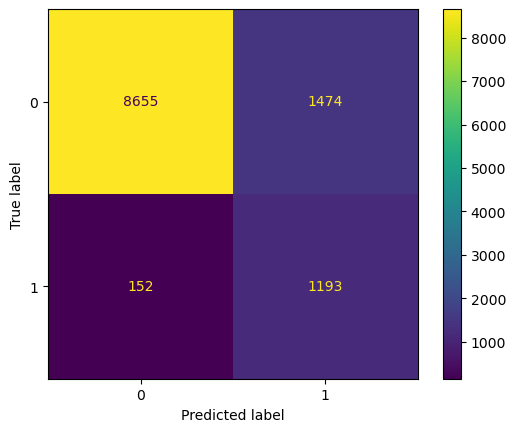

In [55]:
#Define a pipeline with Standard Scaler transformation and Logistic regression classifier
start_time = time.time()
logreg_pipe0 = Pipeline([('scaler', StandardScaler()),('logreg',LogisticRegression(n_jobs=-1,class_weight='balanced'))]).fit(X_train,y_train)
end_time = time.time()

#Calulate time necessary to complete the search
logreg_execution_time0 = end_time - start_time  # Calculate the elapsed time

#Caluculate fidelity scores
preds = logreg_pipe0.predict(X_test)
logreg_acc_train0=logreg_pipe0.score(X_train,y_train)
logreg_acc0 = logreg_pipe0.score(X_test,y_test)
logreg_precision0 = precision_score(y_test, preds, pos_label=1)
logreg_recall0 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = logreg_pipe0.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
logreg_roc_auc_value0 = skl_auc(fpr, tpr)

#Print critical results
print('Time needed to complete:',round(logreg_execution_time0,1),'second')
print('Training Accuracy: ', round(logreg_acc_train0,2))
print('Accuracy: ',round(logreg_acc0,2))
print('Recall: ',round(logreg_recall0,2))
print('Precision: ',round(logreg_precision0,2))
print('ROC AUC: ',round(logreg_roc_auc_value0,2))

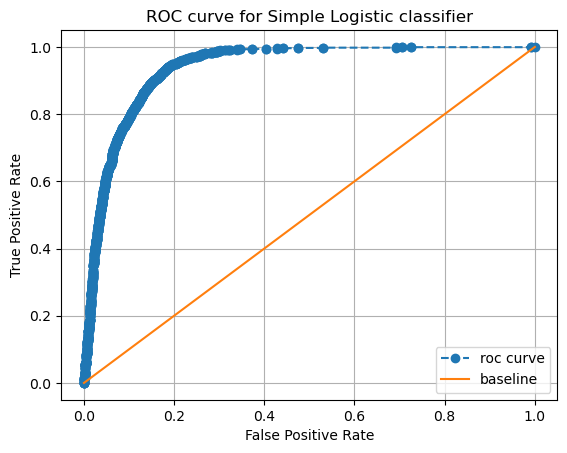

In [56]:
# ROC curve for Simple Logistic classifier 
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC curve for Simple Logistic classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

### Problem 9: Score the Model

What is the accuracy of your model?

In [58]:
df0 = pd.DataFrame({'Model':'Dummy classifier',
                    'Train Time[s]':[round(dummy_execution_time,3)],
                    'Train Accuracy':[round(dummy_acc_train,3)],
                    'Test Accuracy':[round(dummy_acc,3)],
                    'Recall' : [round(dummy_recall,3)],
                    'Precision':[round(dummy_precision,3)],
                    'ROC_AUC':[round(dummy_roc_auc_value,3)]
                   })
df1 = pd.DataFrame({'Model':'Simple Logistic classifier',
                    'Train Time[s]':[round(logreg_execution_time0,3)],
                    'Train Accuracy':[round(logreg_acc_train0,3)],
                    'Test Accuracy':[round(logreg_acc0,3)],
                    'Recall' : [round(logreg_recall0,3)],
                    'Precision':[round(logreg_precision0,3)],
                    'ROC_AUC':[round(logreg_roc_auc_value0,3)]
                    })
summary = pd.concat([df0,df1]).set_index('Model')
summary

,Train Time[s],Train Accuracy,Test Accuracy,Recall,Precision,ROC_AUC
Model,,,,,,
Dummy classifier,0.015,0.891,0.883,0.000,0.000,0.500
Simple Logistic classifier,1.130,0.864,0.858,0.887,0.447,0.937


#### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

#### Simple KNN algorithm

Time needed to complete: 0.01 second
Training Accuracy:  0.931
Accuracy:  0.901
Recall:  0.485
Precision:  0.598
ROC AUC:  0.869


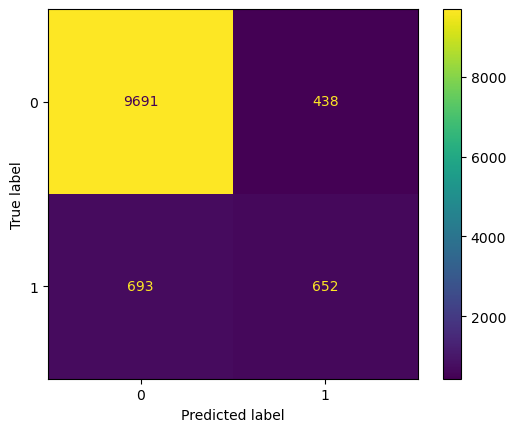

In [61]:
#Fit simple KNeighborsClassifier and calculate time needed to train
start_time = time.time()
knn_pipe = Pipeline([('knn',KNeighborsClassifier(n_jobs=-1))]).fit(X_train,y_train)
end_time = time.time()

#How much time did it take
knn_execution_time0 = end_time - start_time  # Calculate the elapsed time

#Calculate Fidelity scores
preds = knn_pipe.predict(X_test)
knn_acc_train0 = knn_pipe.score(X_train,y_train)
knn_acc0 = knn_pipe.score(X_test,y_test)
knn_precision0 = precision_score(y_test, preds, pos_label=1)
knn_recall0 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = knn_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
knn_roc_auc_value0= skl_auc(fpr, tpr)

#Print critical results
print('Time needed to complete:',round(knn_execution_time0,2),'second')
print('Training Accuracy: ', round(knn_acc_train0,3))
print('Accuracy: ',round(knn_acc0,3))
print('Recall: ',round(knn_recall0,3))
print('Precision: ',round(knn_precision0,3))
print('ROC AUC: ',round(knn_roc_auc_value0,3))

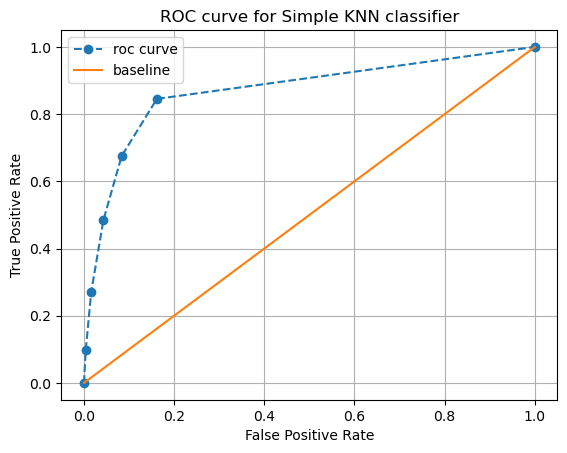

In [62]:
# ROC curve for Simple KNN
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC curve for Simple KNN classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

#### Simple Decision Tree

Time needed to complete: 0.1 second
Training Accuracy:  1.0
Accuracy:  0.89
Recall:  0.5
Precision:  0.52
ROC AUC:  0.72


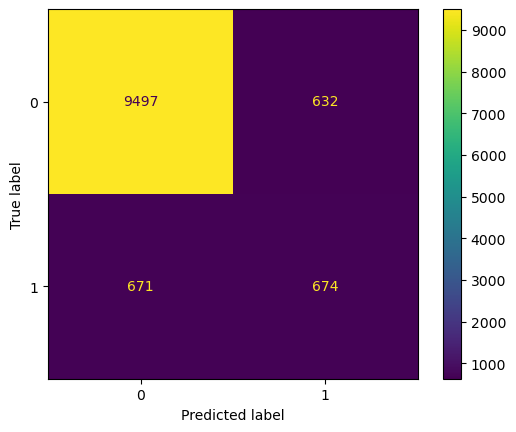

In [64]:
# Fit simple DecisionTreeClassifier and measure required time to complete
start_time = time.time()
dtree_pipe = Pipeline([('tree', DecisionTreeClassifier())]).fit(X_train,y_train)
end_time = time.time()

#How much time did it take to train
tree_execution_time0 = end_time - start_time  # Calculate the elapsed time

#Calculate Fidelity scores
preds = dtree_pipe .predict(X_test)
tree_acc_train0 = dtree_pipe .score(X_train,y_train)
tree_acc0 = dtree_pipe .score(X_test,y_test)
tree_precision0 = precision_score(y_test, preds, pos_label=1)
tree_recall0 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = dtree_pipe .predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
tree_roc_auc_value0 = skl_auc(fpr, tpr)

#Print critical results
print('Time needed to complete:',round(tree_execution_time0,1),'second')
print('Training Accuracy: ', round(tree_acc_train0,2))
print('Accuracy: ',round(tree_acc0,2))
print('Recall: ',round(tree_recall0,2))
print('Precision: ',round(tree_precision0,2))
print('ROC AUC: ',round(tree_roc_auc_value0,2))

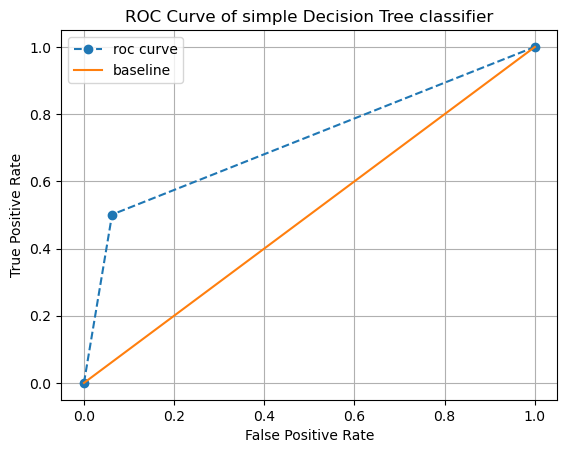

In [65]:
# ROC Curve of simple Decision Tree classifier
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label= 'baseline')
plt.legend()
plt.title('ROC Curve of simple Decision Tree classifier')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

#### Simple SVC

Time needed to complete: 35.2 second
Training Accuracy:  0.9
Accuracy:  0.89
Recall:  0.21
Precision:  0.65
ROC AUC:  0.92


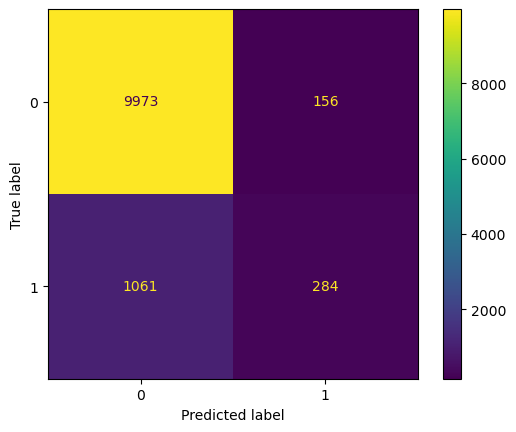

In [67]:
#Fit simple SVC
start_time = time.time()
svc_pipe = Pipeline([('svc',SVC(probability=True,cache_size=90000))]).fit(X_train, y_train)
end_time = time.time()

#How much time did it take to train
svc_execution_time0 = end_time - start_time  

#Calculate Fidelity scores
preds = svc_pipe.predict(X_test)
svc_acc_train0 = svc_pipe.score(X_train,y_train)
svc_acc0 = svc_pipe.score(X_test,y_test)
svc_precision0 = precision_score(y_test, preds, pos_label=1)
svc_recall0 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = svc_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
svc_roc_auc_value0 = skl_auc(fpr, tpr)

#Print critical results
print('Time needed to complete:',round(svc_execution_time0,1),'second')
print('Training Accuracy: ', round(svc_acc_train0,2))
print('Accuracy: ',round(svc_acc0,2))
print('Recall: ',round(svc_recall0,2))
print('Precision: ',round(svc_precision0,2))
print('ROC AUC: ',round(svc_roc_auc_value0,2))

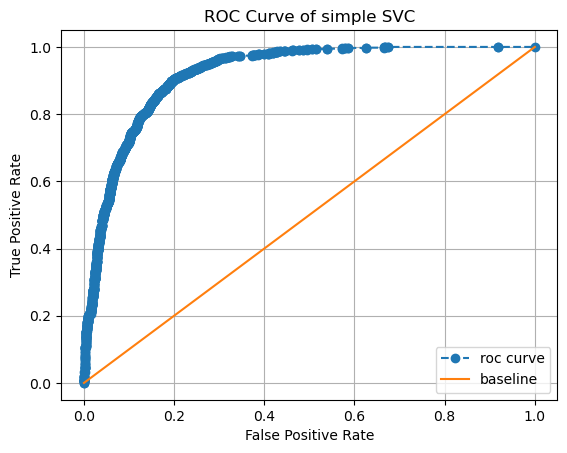

In [68]:
# ROC Curve of simple SVC
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label= 'baseline')
plt.legend()
plt.title('ROC Curve of simple SVC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

#### Models comparison

In [70]:
df0 = pd.DataFrame({'Model':'Dummy classifier',
                    'Train Time[s]':[round(dummy_execution_time,3)],
                    'Train Accuracy':[round(dummy_acc_train,3)],
                    'Test Accuracy':[round(dummy_acc,3)],
                    'Recall' : [round(dummy_recall,3)],
                    'Precision':[round(dummy_precision,3)],
                    'ROC_AUC':[round(dummy_roc_auc_value,3)]
                   })
df1 = pd.DataFrame({'Model':'Simple Logistic classifier',
                    'Train Time[s]':[round(logreg_execution_time0,3)],
                    'Train Accuracy':[round(logreg_acc_train0,3)],
                    'Test Accuracy':[round(logreg_acc0,3)],
                    'Recall' : [round(logreg_recall0,3)],
                    'Precision':[round(logreg_precision0,3)],
                    'ROC_AUC':[round(logreg_roc_auc_value0,3)]
                    })
df2 = pd.DataFrame({'Model':'Simple KNN classifier',
                    'Train Time[s]':[round(knn_execution_time0,3)],
                    'Train Accuracy':[round(knn_acc_train0,3)],
                    'Test Accuracy':[round(knn_acc0,3)],
                    'Recall' : [round(knn_recall0,3)],
                    'Precision':[round(knn_precision0,3)],
                    'ROC_AUC':[round(knn_roc_auc_value0,3)]
                    })
df3 = pd.DataFrame({'Model':'Simple dTree classifier',
                    'Train Time[s]':[round(tree_execution_time0,3)],
                    'Train Accuracy':[round(tree_acc_train0,3)],
                    'Test Accuracy':[round(tree_acc0,3)],
                    'Recall' : [round(tree_recall0,3)],
                    'Precision':[round(tree_precision0,3)],
                    'ROC_AUC':[round(tree_roc_auc_value0,3)]
                    })
df4 = pd.DataFrame({'Model':'Simple SVC',
                    'Train Time[s]':[round(svc_execution_time0,3)],
                    'Train Accuracy':[round(svc_acc_train0,3)],
                    'Test Accuracy':[round(svc_acc0,3)],
                    'Recall' : [round(svc_recall0,3)],
                    'Precision':[round(svc_precision0,3)],
                    'ROC_AUC':[round(svc_roc_auc_value0,3)]
                    })
summary1 = pd.concat([df0,df1,df2,df3,df4]).set_index('Model')
summary1

,Train Time[s],Train Accuracy,Test Accuracy,Recall,Precision,ROC_AUC
Model,,,,,,
Dummy classifier,0.015,0.891,0.883,0.000,0.000,0.500
Simple Logistic classifier,1.130,0.864,0.858,0.887,0.447,0.937
Simple KNN classifier,0.006,0.931,0.901,0.485,0.598,0.869
Simple dTree classifier,0.130,1.000,0.886,0.501,0.516,0.719
Simple SVC,35.175,0.900,0.894,0.211,0.645,0.920


### Problem 11: Improving the Model:
    Test hyperparameter search using RandomisedSearchCV on KNN, Decision trees, Logistic regression and SVM
    Test balancing data with SMOTE method
    Test multiple scoring methodology with ROC_AUC and recall

### Dummy classifier with SMOTE balanced data

Time needed to complete: 0.0 second
Training Accuracy:  0.5
Accuracy:  0.88
Recall:  0.0
Precision:  0.0
ROC AUC:  0.5


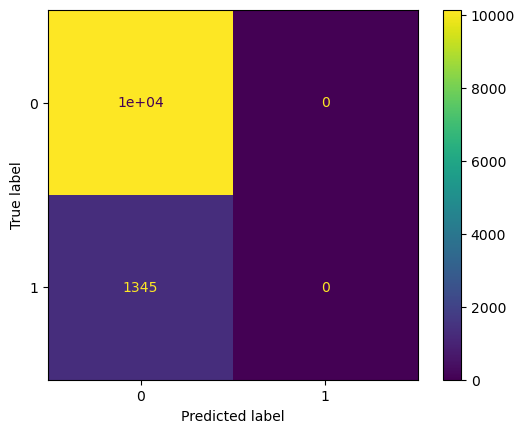

In [73]:
#Define Dummy Classifer pipeline, and measure time necessary to train
start_time = time.time()
dummy_pipe = Pipeline([('dummy',DummyClassifier())]).fit(X_resampled,y_resampled)
end_time = time.time()

#How much time did it take
dummy_execution_time1 = end_time - start_time  # Calculate the elapsed time


#Caluculate fidelity scores
preds = dummy_pipe.predict(X_test)
dummy_acc_train1 = dummy_pipe.score(X_resampled,y_resampled)
dummy_acc1 = dummy_pipe.score(X_test,y_test)
dummy_precision1 = precision_score(y_test, preds, pos_label=1)
dummy_recall1 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = dummy_pipe.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
dummy_roc_auc_value1 = skl_auc(fpr, tpr)

#Print results
print('Time needed to complete:',round(dummy_execution_time1,1),'second')
print('Training Accuracy: ',round(dummy_acc_train1,2))
print('Accuracy: ',round(dummy_acc1,2))
print('Recall: ',round(dummy_recall1,2))
print('Precision: ',round(dummy_precision1,2))
print('ROC AUC: ',round(dummy_roc_auc_value1,2))

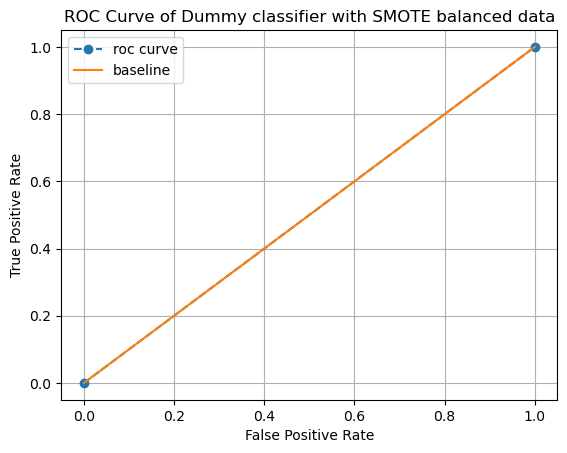

In [74]:
# ROC Curve of Dummy classifier with SMOTE balanced data
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve of Dummy classifier with SMOTE balanced data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

### Hyperparameter search: Logistic regression - unbalanced data

Time needed to complete: 450 second
Best parameters:  {'poly_features__include_bias': True, 'poly_features__degree': 1, 'logreg__tol': 0.001, 'logreg__penalty': 'l2', 'logreg__l1_ratio': 1.0, 'logreg__fit_intercept': False, 'logreg__class_weight': 'balanced', 'logreg__C': 0.005994842503189409}
Training Accuracy:  0.75
Accuracy:  0.76
Recall:  0.98
Precision:  0.32
ROC AUC:  0.94


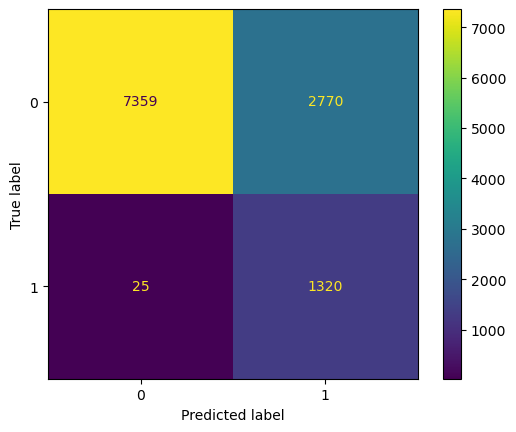

In [76]:
#Define a pipeline with Standard Scaler transformation, followed by Polynomial features transformation and Logistic regression classifier
logreg_pipe = Pipeline([('poly_features', PolynomialFeatures()),('scaler', StandardScaler()),('logreg',LogisticRegression(n_jobs=-1, max_iter=2000))])

#Hyperparameter dictionary to search
param_logreg = {
    'logreg__C': np.logspace(-4, 4, 10),
    'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
#    'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga', 'sag', 'newton-cholesky'],  # 'newton-cg' and 'sag' only support l2
    'logreg__class_weight': [None, 'balanced'],
    'logreg__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0],
    'logreg__tol': [1e-4, 1e-3, 1e-2],
    'logreg__fit_intercept': [True, False],
    'poly_features__degree': [1,2,3],
    'poly_features__include_bias': [True, False]
}
#RandomizedSearchCV of Logistic regression over hyperparameters
start_time = time.time()
logreg_grid1 = RandomizedSearchCV(logreg_pipe, param_distributions=param_logreg, scoring=['roc_auc','recall'], refit='recall', n_jobs=4,n_iter=20,pre_dispatch='2*n_jobs').fit(X_train,y_train)
end_time = time.time()

#Calulate time necessary to complete the search
logreg_execution_time1 = end_time - start_time  # Calculate the elapsed time

#Recall best hyperparameters
logreg_best1 = logreg_grid1.best_params_

#Caluculate fidelity scores
preds = logreg_grid1.best_estimator_.predict(X_test)
logreg_acc_train1 = logreg_grid1.best_estimator_.score(X_train,y_train)
logreg_acc1 = logreg_grid1.best_estimator_.score(X_test,y_test)
logreg_precision1 = precision_score(y_test, preds, pos_label=1)
logreg_recall1 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = logreg_grid1.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
logreg_roc_auc_value1 = skl_auc(fpr, tpr)

#Print critical results
print('Time needed to complete:',round(logreg_execution_time1),'second')
print('Best parameters: ',logreg_best1)
print('Training Accuracy: ', round(logreg_acc_train1,2))
print('Accuracy: ',round(logreg_acc1,2))
print('Recall: ',round(logreg_recall1,2))
print('Precision: ',round(logreg_precision1,2))
print('ROC AUC: ',round(logreg_roc_auc_value1,2))

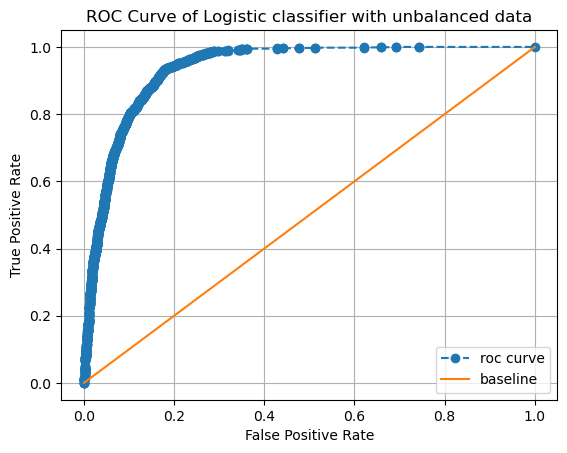

In [77]:
# ROC Curve of Logistic classifier with unbalanced data
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve of Logistic classifier with unbalanced data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

### Hyperparameter search: Logistic regression - SMOTE balanced data

Time needed to complete: 873.3 second
Best parameters:  {'poly_features__include_bias': True, 'poly_features__degree': 1, 'logreg__tol': 0.01, 'logreg__penalty': 'l2', 'logreg__l1_ratio': 0.25, 'logreg__fit_intercept': False, 'logreg__class_weight': 'balanced', 'logreg__C': 0.3593813663804626}
Training Accuracy:  0.75
Accuracy:  0.76
Recall:  0.98
Precision:  0.32
ROC AUC:  0.94


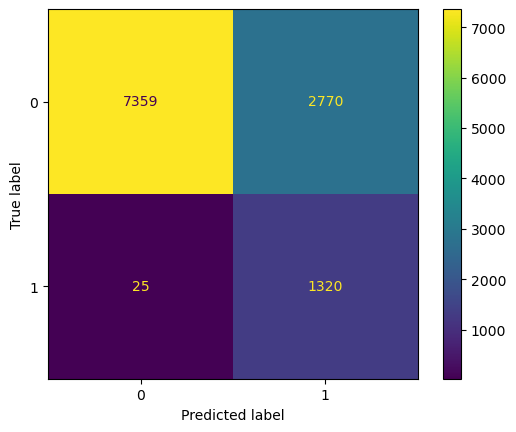

In [79]:
#Define a pipeline with Standard Scaler transformation, followed by Polynomial features transformation and Logistic regression classifier
logreg_pipe = Pipeline([('poly_features', PolynomialFeatures()),('scaler',StandardScaler()),('logreg',LogisticRegression(n_jobs=-1, max_iter=2000,class_weight='balanced'))])

#Hyperparameter dictionary to search
param_logreg = {
    'logreg__C': np.logspace(-4, 4, 10),
    'logreg__penalty': ['l1', 'l2', 'elasticnet', 'none'],
#    'logreg__solver': ['newton-cg', 'lbfgs', 'liblinear', 'saga', 'sag', 'newton-cholesky'],  # 'newton-cg' and 'sag' only support l2
    'logreg__class_weight': [None, 'balanced'],
    'logreg__l1_ratio': [0.0, 0.25, 0.5, 0.75, 1.0],
    'logreg__tol': [1e-4, 1e-3, 1e-2],
    'logreg__fit_intercept': [True, False],
    'poly_features__degree': [1,2,3],
    'poly_features__include_bias': [True, False]
}
#RandomizedSearchCV of Logistic regression over hyperparameters
start_time = time.time()
logreg_grid = RandomizedSearchCV(logreg_pipe, param_distributions=param_logreg, scoring=['roc_auc','recall'], refit='recall',n_jobs=4,n_iter=20,pre_dispatch='2*n_jobs').fit(X_train,y_train)
end_time = time.time()

#Calulate time necessary to complete the search
logreg_execution_time2 = end_time - start_time  # Calculate the elapsed time

#Recall best hyperparameters
logreg_best2 = logreg_grid.best_params_

#Caluculate fidelity scores
preds = logreg_grid.best_estimator_.predict(X_test)
logreg_acc_train2 =logreg_grid.best_estimator_.score(X_train,y_train)
logreg_acc2 = logreg_grid.best_estimator_.score(X_test,y_test)
logreg_precision2 = precision_score(y_test, preds, pos_label=1)
logreg_recall2 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = logreg_grid.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
logreg_roc_auc_value2 = skl_auc(fpr, tpr)

#Print critical results
print('Time needed to complete:',round(logreg_execution_time2,1),'second')
print('Best parameters: ',logreg_best2)
print('Training Accuracy: ', round(logreg_acc_train2,2))
print('Accuracy: ',round(logreg_acc2,2))
print('Recall: ',round(logreg_recall2,2))
print('Precision: ',round(logreg_precision2,2))
print('ROC AUC: ',round(logreg_roc_auc_value2,2))

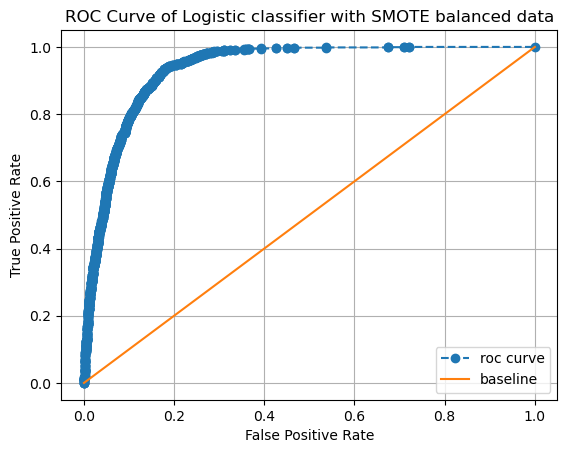

In [80]:
# ROC Curve of Logistic classifier with SMOTE balanced data
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve of Logistic classifier with SMOTE balanced data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

#### Hyperparameter search: KNN - unbalanced data

Time needed to complete: 33.6 second
Best parameters:  {'knn__weights': 'uniform', 'knn__p': 1, 'knn__n_neighbors': 13, 'knn__metric': 'manhattan'}
Training Accuracy:  0.92
Accuracy:  0.91
Recall:  0.5
Precision:  0.63
ROC AUC:  0.91


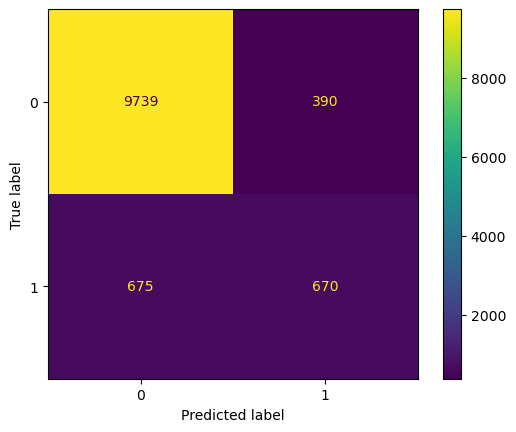

In [82]:
#Define the KNN pipeline of KNeighborsClassifier
knn_pipe = Pipeline([('knn',KNeighborsClassifier(n_jobs=-1))])
# Hyperparameters to search
params_knn = {'knn__n_neighbors':[1,3,5,7,9,11,13,15,17,19,21],
              'knn__weights' : ('uniform', 'distance'),
              'knn__p' :[1, 2],
              'knn__metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
             }
#Perform RandomizedSearchCV on knn_pipe and fit data
start_time = time.time()
knn_grid = RandomizedSearchCV(knn_pipe, param_distributions=params_knn, scoring=['roc_auc','recall'], refit='recall',n_jobs=4,n_iter=20,pre_dispatch='2*n_jobs').fit(X_train,y_train)
end_time = time.time()

#How much time did it take
knn_execution_time1 = end_time - start_time  # Calculate the elapsed time

#What were the best parameters
knn_best1 = knn_grid.best_params_

# Calculate fidelity scores
preds = knn_grid.best_estimator_.predict(X_test)
knn_acc_train1 = knn_grid.best_estimator_.score(X_train,y_train)
knn_acc1 = knn_grid.best_estimator_.score(X_test,y_test)
knn_precision1 = precision_score(y_test, preds, pos_label=1)
knn_recall1 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = knn_grid.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
knn_roc_auc_value1 = skl_auc(fpr, tpr)

#Print critical results
print('Time needed to complete:',round(knn_execution_time1,1),'second')
print('Best parameters: ',knn_best1)
print('Training Accuracy: ', round(knn_acc_train1,2))
print('Accuracy: ',round(knn_acc1,2))
print('Recall: ',round(knn_recall1,2))
print('Precision: ',round(knn_precision1,2))
print('ROC AUC: ',round(knn_roc_auc_value1,2))

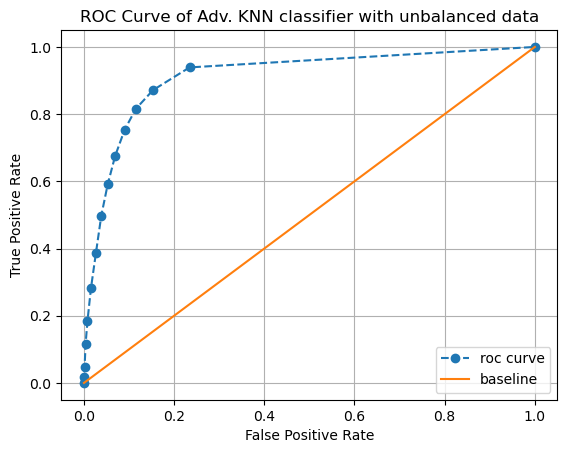

In [83]:
# ROC Curve of Adv. KNN classifier with unbalanced data
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve of Adv. KNN classifier with unbalanced data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

#### Hyperparameter search: KNN - SMOTE balanced data

Time needed to complete: 161.3 second
Best parameters:  {'knn__weights': 'distance', 'knn__p': 1, 'knn__n_neighbors': 7, 'knn__metric': 'minkowski'}
Training Accuracy:  1.0
Accuracy:  0.85
Recall:  0.84
Precision:  0.43
ROC AUC:  0.9


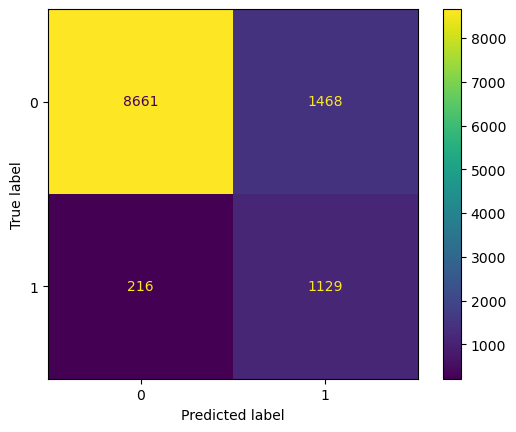

In [85]:
#Define the KNN pipeline of KNeighborsClassifier
knn_pipe = Pipeline([('knn',KNeighborsClassifier(n_jobs=-1))])
#Hyperparameters to search
params_knn = {'knn__n_neighbors':[1,3,5,7,9,11,13,15,17,19,21],
              'knn__weights' : ('uniform', 'distance'),
              'knn__p' :[1, 2],
              'knn__metric': ['minkowski', 'euclidean', 'manhattan', 'chebyshev'],
             }
#Perform RandomizedSearchCV on knn_pipe and fit data
start_time = time.time()
knn_grid = RandomizedSearchCV(knn_pipe, param_distributions=params_knn, scoring=['roc_auc','recall'], refit='recall',n_jobs=4,n_iter=20,pre_dispatch='2*n_jobs').fit(X_resampled,y_resampled)
end_time = time.time()

#How much time did it take to train 
knn_execution_time2 = end_time - start_time  # Calculate the elapsed time

#What were the best parameters
knn_best2 = knn_grid.best_params_

# Calculate fidelity scores
preds = knn_grid.best_estimator_.predict(X_test)
knn_acc_train2 = knn_grid.best_estimator_.score(X_resampled,y_resampled)
knn_acc2 = knn_grid.best_estimator_.score(X_test,y_test)
knn_precision2 = precision_score(y_test, preds, pos_label=1)
knn_recall2 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = knn_grid.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
knn_roc_auc_value2 = skl_auc(fpr, tpr)

#Print critical results
print('Time needed to complete:',round(knn_execution_time2,1),'second')
print('Best parameters: ',knn_best2)
print('Training Accuracy: ', round(knn_acc_train2,2))
print('Accuracy: ',round(knn_acc2,2))
print('Recall: ',round(knn_recall2,2))
print('Precision: ',round(knn_precision2,2))
print('ROC AUC: ',round(knn_roc_auc_value2,2))

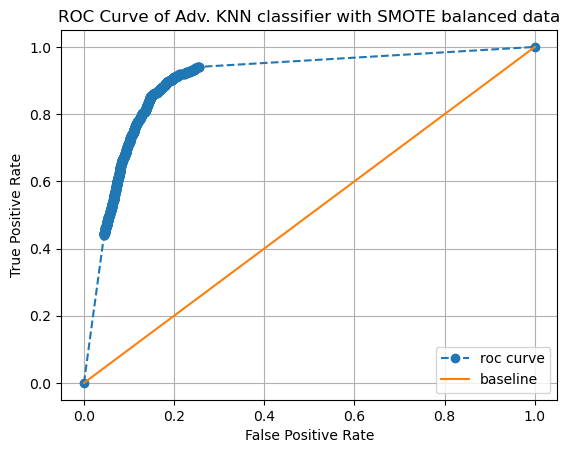

In [86]:
# ROC Curve of Adv. KNN classifier with SMOTE balanced data
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve of Adv. KNN classifier with SMOTE balanced data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

#### Hyperparameter search: Decision tree - unbalanced data

Time needed to complete: 9.7 second
Best parameters:  {'tree__min_samples_split': 32, 'tree__min_samples_leaf': 2, 'tree__max_depth': None, 'tree__criterion': 'entropy'}
Training Accuracy:  0.95
Accuracy:  0.9
Recall:  0.52
Precision:  0.58
ROC AUC:  0.87


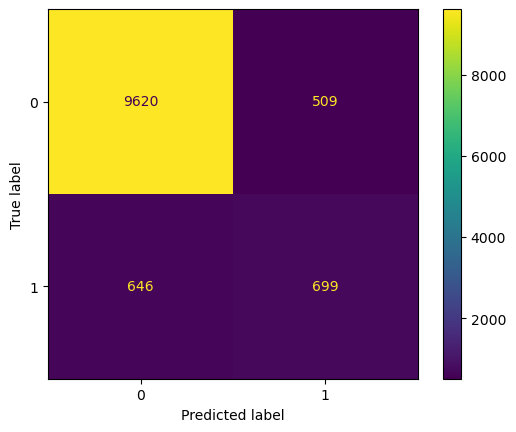

In [88]:
#Define the Decision tree pipeline of DecisionTreeClassifier
dtree_pipe = Pipeline([('tree', DecisionTreeClassifier())])

#Hyperparameters to search
params = {
    'tree__max_depth': [None,3,6,12,24,48],  # Try a range of depths or leave as None for no limit
    'tree__min_samples_split': [2,4,8,16,32],  # Minimum number of samples required to split a node
    'tree__criterion': ['gini', 'entropy'],  # Metrics to measure the quality of a split
    'tree__min_samples_leaf': [1,2,4,8,16],  # Minimum number of samples required at a leaf node
}
#Perform RandomizedSearchCV on dtree_pipe and fit data, measure time necessary for training
start_time = time.time()
dtree_randomizedgrid = RandomizedSearchCV(dtree_pipe, param_distributions=params, scoring=['roc_auc','recall'], refit='recall',n_jobs=4,n_iter=100,pre_dispatch='2*n_jobs').fit(X_train,y_train)
end_time = time.time()

#How much time did it take to train 
tree_execution_time1 = end_time - start_time  # Calculate the elapsed time

#What were the best parameters
tree_best1 = dtree_randomizedgrid.best_params_

# Calculate fidelity scores
preds = dtree_randomizedgrid.best_estimator_.predict(X_test)
tree_acc_train1 = dtree_randomizedgrid.best_estimator_.score(X_train,y_train)
tree_acc1 = dtree_randomizedgrid.best_estimator_.score(X_test,y_test)
tree_precision1 = precision_score(y_test, preds, pos_label=1)
tree_recall1 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = dtree_randomizedgrid.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
tree_roc_auc_value1 = skl_auc(fpr, tpr)

#Print critical results
print('Time needed to complete:',round(tree_execution_time1,1),'second')
print('Best parameters: ',tree_best1)
print('Training Accuracy: ', round(tree_acc_train1,2))
print('Accuracy: ',round(tree_acc1,2))
print('Recall: ',round(tree_recall1,2))
print('Precision: ',round(tree_precision1,2))
print('ROC AUC: ',round(tree_roc_auc_value1,2))

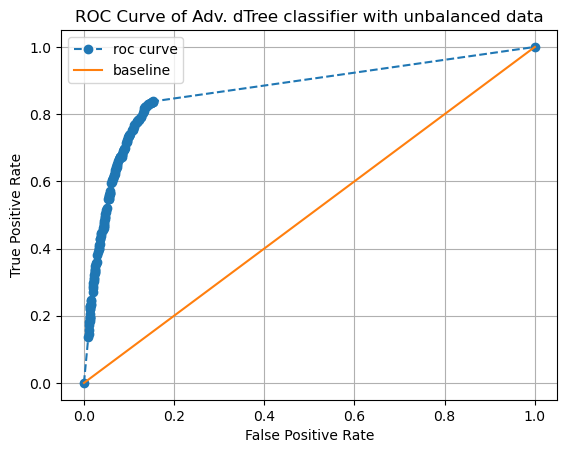

In [89]:
# ROC Curve of Adv. dTree classifier with unbalanced data
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve of Adv. dTree classifier with unbalanced data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

#### Hyperparameter search: Decision tree - SMOTE balanced data

Time needed to complete: 20.3 second
Best parameters:  {'tree__min_samples_split': 2, 'tree__min_samples_leaf': 4, 'tree__max_depth': 6, 'tree__criterion': 'entropy'}
Training Accuracy:  0.91
Accuracy:  0.87
Recall:  0.81
Precision:  0.46
ROC AUC:  0.92


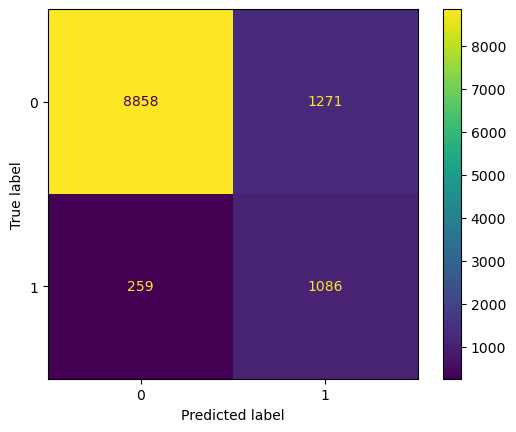

In [91]:
#Define the Decision tree pipeline of  DecisionTreeClassifier
dtree_pipe = Pipeline([('tree', DecisionTreeClassifier())])

#Hyperparameters to search
params = {
    'tree__max_depth': [None,3,6,12,24,48],  # Try a range of depths or leave as None for no limit
    'tree__min_samples_split': [2,4,8,16,32],  # Minimum number of samples required to split a node
    'tree__criterion': ['gini', 'entropy'],  # Metrics to measure the quality of a split
    'tree__min_samples_leaf': [1,2,4,8,16],  # Minimum number of samples required at a leaf node
}
#Perform RandomizedSearchCV on dtree_pipe and fit data, measure time necessary for training
start_time = time.time()
dtree_randomizedgrid = RandomizedSearchCV(dtree_pipe, param_distributions=params, scoring=['roc_auc','recall'], refit='recall',n_jobs=4,n_iter=100,pre_dispatch='2*n_jobs').fit(X_resampled,y_resampled)
end_time = time.time()

#How much time did it take to train 
tree_execution_time2 = end_time - start_time  # Calculate the elapsed time

#What were the best parameters
tree_best2 = dtree_randomizedgrid.best_params_

# Calculate fidelity scores
preds = dtree_randomizedgrid.best_estimator_.predict(X_test)
tree_acc_train2 = dtree_randomizedgrid.best_estimator_.score(X_resampled,y_resampled)
tree_acc2 = dtree_randomizedgrid.best_estimator_.score(X_test,y_test)
tree_precision2 = precision_score(y_test, preds, pos_label=1)
tree_recall2 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = dtree_randomizedgrid.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
tree_roc_auc_value2 = skl_auc(fpr, tpr)

#Print critical results
print('Time needed to complete:',round(tree_execution_time2,1),'second')
print('Best parameters: ',tree_best2)
print('Training Accuracy: ', round(tree_acc_train2,2))
print('Accuracy: ',round(tree_acc2,2))
print('Recall: ',round(tree_recall2,2))
print('Precision: ',round(tree_precision2,2))
print('ROC AUC: ',round(tree_roc_auc_value2,2))

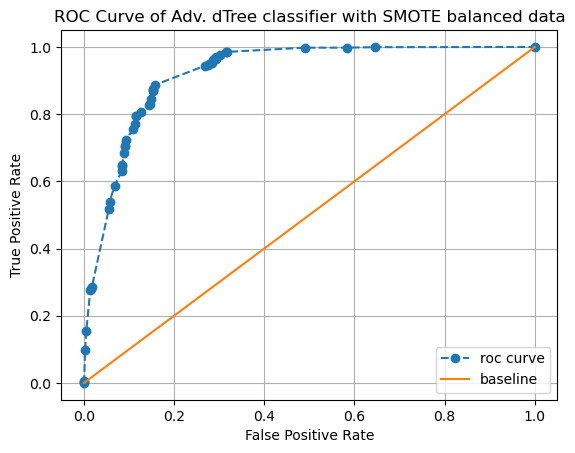

In [92]:
# ROC Curve of Adv. dTree classifier with SMOTE balanced data
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve of Adv. dTree classifier with SMOTE balanced data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

#### Hyperparameter search: SVC - unbalanced data

Time needed to complete: 643.7 second
Best parameters:  {'svc__tol': 0.01, 'svc__C': 0.1}
Training Accuracy:  0.9
Accuracy:  0.89
Recall:  0.19
Precision:  0.68
ROC AUC:  0.93


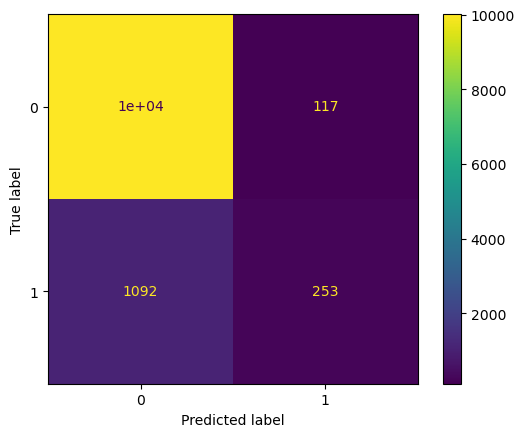

In [95]:
#Define the SVC tree pipeline of Standrd Scaler, and SVC
svc_pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(probability=True, cache_size=90000,max_iter=10000))])

#Hyperparameters to search
svc_params= {
    'svc__C': [0.1, 1, 10, 100, 1000],         # Regularization strength
#   'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Types of kernel functions
#    'svc__gamma': ['scale', 'auto'],     # Kernel coefficient
#    'svc__coef0': [0.0, 0.5, 1.0],       # Independent term in poly/sigmoid kernel
    'svc__tol': [1e-4, 1e-3, 1e-2]       # Tolerance for stopping criterion
}

#Perform RandomizedSearchCV on dtree_pipe and fit data, measure time necessary for training
start_time = time.time()
svc_grid = RandomizedSearchCV(svc_pipe, param_distributions=svc_params, scoring='roc_auc',n_jobs=-1,n_iter=20).fit(X_train,y_train)
end_time = time.time()

#How much time did it take to train 
svc_execution_time1 = end_time - start_time 

#What were the best parameters
svc_best1 = svc_grid.best_params_

# Calculate fidelity scores
preds = svc_grid.best_estimator_.predict(X_test)
svc_acc_train1 = svc_grid.best_estimator_.score(X_train,y_train)
svc_acc1 = svc_grid.best_estimator_.score(X_test,y_test)
svc_precision1 = precision_score(y_test, preds, pos_label=1)
svc_recall1 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = svc_grid.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
svc_roc_auc_value1 = skl_auc(fpr, tpr)

#Print critical results
print('Time needed to complete:',round(svc_execution_time1,1),'second')
print('Best parameters: ',svc_best1)
print('Training Accuracy: ', round(svc_acc_train1,2))
print('Accuracy: ',round(svc_acc1,2))
print('Recall: ',round(svc_recall1,2))
print('Precision: ',round(svc_precision1,2))
print('ROC AUC: ',round(svc_roc_auc_value1,2))

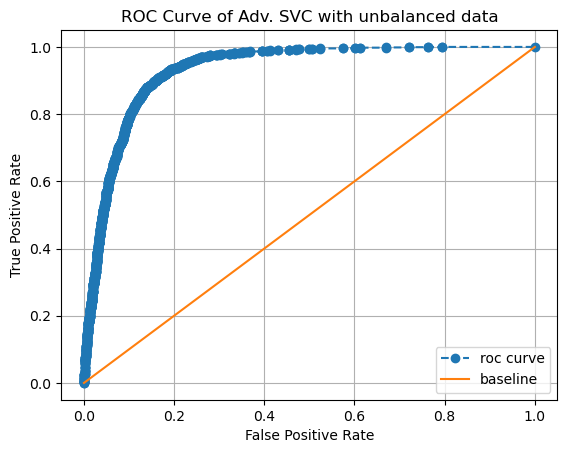

In [96]:
# ROC Curve of Adv. SVC with unbalanced data
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve of Adv. SVC with unbalanced data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

#### Hyperparameter search: SVC - SMOTE balanced data

Time needed to complete: 1967.0 second
Best parameters:  {'svc__tol': 0.0001, 'svc__C': 0.1}
Training Accuracy:  0.95
Accuracy:  0.9
Recall:  0.24
Precision:  0.65
ROC AUC:  0.93


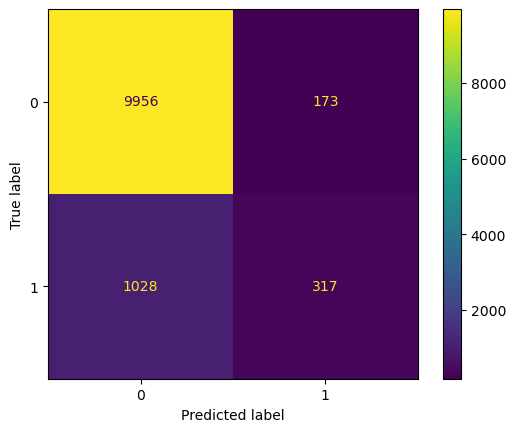

In [106]:
#Define the SVC tree pipeline of Standrd Scaler, and SVC
svc_pipe = Pipeline([('scaler',StandardScaler()),('svc',SVC(probability=True, cache_size=90000,max_iter=10000))])

#Hyperparameters to search
svc_params= {
    'svc__C': [0.1, 1, 10, 100, 1000],         # Regularization strength
#   'svc__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],  # Types of kernel functions
#    'svc__gamma': ['scale', 'auto'],     # Kernel coefficient
#    'svc__coef0': [0.0, 0.5, 1.0],       # Independent term in poly/sigmoid kernel
    'svc__tol': [1e-4, 1e-3, 1e-2]       # Tolerance for stopping criterion
}

#Perform RandomizedSearchCV on dtree_pipe and fit data, measure time necessary for training
start_time = time.time()
svc_grid = RandomizedSearchCV(svc_pipe, param_distributions=svc_params, scoring='roc_auc',n_jobs=-1,n_iter=20).fit(X_resampled,y_resampled)
end_time = time.time()

#How much time did it take to train 
svc_execution_time2 = end_time - start_time 

#What were the best parameters
svc_best2 = svc_grid.best_params_

# Calculate fidelity scores
preds = svc_grid.best_estimator_.predict(X_test)
svc_acc_train2 = svc_grid.best_estimator_.score(X_resampled,y_resampled)
svc_acc2 = svc_grid.best_estimator_.score(X_test,y_test)
svc_precision2 = precision_score(y_test, preds, pos_label=1)
svc_recall2 = recall_score(y_test, preds, pos_label=1)

# Calculate Confusion Matrix
confusion_mat = confusion_matrix(y_test,preds,labels=[0,1])
dist = ConfusionMatrixDisplay(confusion_matrix=confusion_mat, display_labels=[0,1]).plot()

#Calculate ROC AUC
y_score = svc_grid.best_estimator_.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)
svc_roc_auc_value2 = skl_auc(fpr, tpr)

#Print critical results
print('Time needed to complete:',round(svc_execution_time2,1),'second')
print('Best parameters: ',svc_best2)
print('Training Accuracy: ', round(svc_acc_train2,2))
print('Accuracy: ',round(svc_acc2,2))
print('Recall: ',round(svc_recall2,2))
print('Precision: ',round(svc_precision2,2))
print('ROC AUC: ',round(svc_roc_auc_value2,2))

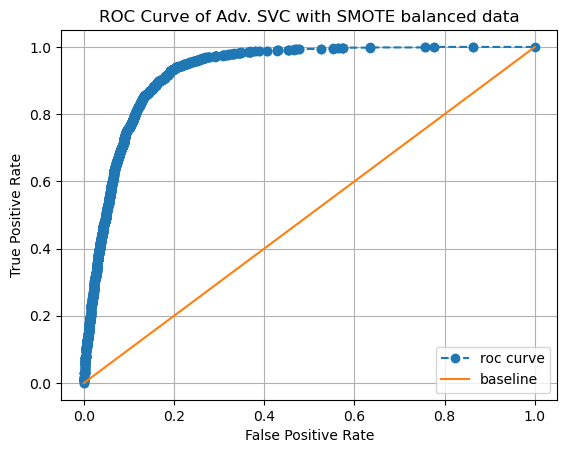

In [107]:
# ROC Curve of Adv. SVC with SMOTE balanced data
plt.plot(fpr, tpr, '--o', label = 'roc curve')
plt.plot(tpr, tpr, label = 'baseline')
plt.legend()
plt.title('ROC Curve of Adv. SVC with SMOTE balanced data')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid();

#### Summary

In [110]:
df0 = pd.DataFrame({'Model':'Dummy classifier',
                    'Train Time[s]':[round(dummy_execution_time,3)],
                    'Train Accuracy':[round(dummy_acc_train,3)],
                    'Test Accuracy':[round(dummy_acc,3)],
                    'Recall' : [round(dummy_recall,3)],
                    'Precision':[round(dummy_precision,3)],
                    'ROC_AUC':[round(dummy_roc_auc_value,3)]
                   })
df1 = pd.DataFrame({'Model':'Simple Logistic classifier',
                    'Train Time[s]':[round(logreg_execution_time0,3)],
                    'Train Accuracy':[round(logreg_acc_train0,3)],
                    'Test Accuracy':[round(logreg_acc0,3)],
                    'Recall' : [round(logreg_recall0,3)],
                    'Precision':[round(logreg_precision0,3)],
                    'ROC_AUC':[round(logreg_roc_auc_value0,3)]
                    })
df2 = pd.DataFrame({'Model':'Simple KNN classifier',
                    'Train Time[s]':[round(knn_execution_time0,3)],
                    'Train Accuracy':[round(knn_acc_train0,3)],
                    'Test Accuracy':[round(knn_acc0,3)],
                    'Recall' : [round(knn_recall0,3)],
                    'Precision':[round(knn_precision0,3)],
                    'ROC_AUC':[round(knn_roc_auc_value0,3)]
                    })
df3 = pd.DataFrame({'Model':'Simple dTree classifier',
                    'Train Time[s]':[round(tree_execution_time0,3)],
                    'Train Accuracy':[round(tree_acc_train0,3)],
                    'Test Accuracy':[round(tree_acc0,3)],
                    'Recall' : [round(tree_recall0,3)],
                    'Precision':[round(tree_precision0,3)],
                    'ROC_AUC':[round(tree_roc_auc_value0,3)]
                    })
df4 = pd.DataFrame({'Model':'Simple SVC',
                    'Train Time[s]':[round(svc_execution_time0,3)],
                    'Train Accuracy':[round(svc_acc_train0,3)],
                    'Test Accuracy':[round(svc_acc0,3)],
                    'Recall' : [round(svc_recall0,3)],
                    'Precision':[round(svc_precision0,3)],
                    'ROC_AUC':[round(svc_roc_auc_value0,3)]
                    })
df5 = pd.DataFrame({'Model':'Adv Logistic classifier',
                    'Train Time[s]':[round(logreg_execution_time1,3)],
                    'Train Accuracy':[round(logreg_acc_train1,3)],
                    'Test Accuracy':[round(logreg_acc1,3)],
                    'Recall' : [round(logreg_recall1,3)],
                    'Precision':[round(logreg_precision1,3)],
                    'ROC_AUC':[round(logreg_roc_auc_value1,3)]
                    })
df6 = pd.DataFrame({'Model':'Adv KNN classifier',
                    'Train Time[s]':[round(knn_execution_time1,3)],
                    'Train Accuracy':[round(knn_acc_train1,3)],
                    'Test Accuracy':[round(knn_acc1,3)],
                    'Recall' : [round(knn_recall1,3)],
                    'Precision':[round(knn_precision1,3)],
                    'ROC_AUC':[round(knn_roc_auc_value1,3)]
                    })
df7 = pd.DataFrame({'Model':'Adv dTree classifier',
                    'Train Time[s]':[round(tree_execution_time1,3)],
                    'Train Accuracy':[round(tree_acc_train1,3)],
                    'Test Accuracy':[round(tree_acc1,3)],
                    'Recall' : [round(tree_recall1,3)],
                    'Precision':[round(tree_precision1,3)],
                    'ROC_AUC':[round(tree_roc_auc_value1,3)]
                    })
df8 = pd.DataFrame({'Model':'Adv SVC',
                    'Train Time[s]':[round(svc_execution_time1,3)],
                    'Train Accuracy':[round(svc_acc_train1,3)],
                    'Test Accuracy':[round(svc_acc1,3)],
                    'Recall' : [round(svc_recall1,3)],
                    'Precision':[round(svc_precision1,3)],
                    'ROC_AUC':[round(svc_roc_auc_value1,3)]
                    })
df9 = pd.DataFrame({'Model':'Dummy classifier SMOTE',
                    'Train Time[s]':[round(dummy_execution_time1,3)],
                    'Train Accuracy':[round(dummy_acc_train1,3)],
                    'Test Accuracy':[round(dummy_acc1,3)],
                    'Recall' : [round(dummy_recall1,3)],
                    'Precision':[round(dummy_precision1,3)],
                    'ROC_AUC':[round(dummy_roc_auc_value1,3)]
                   })
df10 = pd.DataFrame({'Model':'Adv Logistic classifier SMOTE',
                    'Train Time[s]':[round(logreg_execution_time2,3)],
                    'Train Accuracy':[round(logreg_acc_train2,3)],
                    'Test Accuracy':[round(logreg_acc2,3)],
                    'Recall' : [round(logreg_recall2,3)],
                    'Precision':[round(logreg_precision2,3)],
                    'ROC_AUC':[round(logreg_roc_auc_value2,3)]
                    })
df11 = pd.DataFrame({'Model':'Adv KNN classifier SMOTE',
                    'Train Time[s]':[round(knn_execution_time2,3)],
                    'Train Accuracy':[round(knn_acc_train2,3)],
                    'Test Accuracy':[round(knn_acc2,3)],
                    'Recall' : [round(knn_recall2,3)],
                    'Precision':[round(knn_precision2,3)],
                    'ROC_AUC':[round(knn_roc_auc_value2,3)]
                    })
df12 = pd.DataFrame({'Model':'Adv dTree classifier SMOTE',
                    'Train Time[s]':[round(tree_execution_time2,3)],
                    'Train Accuracy':[round(tree_acc_train2,3)],
                    'Test Accuracy':[round(tree_acc2,3)],
                    'Recall' : [round(tree_recall2,3)],
                    'Precision':[round(tree_precision2,3)],
                    'ROC_AUC':[round(tree_roc_auc_value2,3)]
                    })
df13 = pd.DataFrame({'Model':'Adv SVC SMOTE',
                    'Train Time[s]':[round(svc_execution_time2,3)],
                    'Train Accuracy':[round(svc_acc_train2,3)],
                    'Test Accuracy':[round(svc_acc2,3)],
                    'Recall' : [round(svc_recall2,3)],
                    'Precision':[round(svc_precision2,3)],
                    'ROC_AUC':[round(svc_roc_auc_value2,3)]
                    })
summary1 = pd.concat([df0,df1,df2,df3,df4,df5,df6,df7,df8,df9,df10,df11,df12,df13]).set_index('Model')
summary1

,Train Time[s],Train Accuracy,Test Accuracy,Recall,Precision,ROC_AUC
Model,,,,,,
Dummy classifier,0.015,0.891,0.883,0.000,0.000,0.500
Simple Logistic classifier,1.130,0.864,0.858,0.887,0.447,0.937
Simple KNN classifier,0.006,0.931,0.901,0.485,0.598,0.869
Simple dTree classifier,0.130,1.000,0.886,0.501,0.516,0.719
Simple SVC,35.175,0.900,0.894,0.211,0.645,0.920
Adv Logistic classifier,450.215,0.752,0.756,0.981,0.323,0.936
Adv KNN classifier,33.574,0.923,0.907,0.498,0.632,0.912
Adv dTree classifier,9.686,0.946,0.899,0.520,0.579,0.868
Adv SVC,643.684,0.903,0.895,0.188,0.684,0.931


#### Table summary of all models:
    1. Dummy classifiers - represented baseline results, 
    2. Preffix Simple - no hyperparameter search involved, dataset unbalanced
    3. preffix Adv - RandomSerachCV hyperparameter search,
    4. Suffix SMOTE - data was balanced using Synthetic Minority Oversampling Technique (SMOTE)

#### Evaluation metrics
    1. ROC AUC
    2. Recall

#### Evaluation metrics rationale
    1.ROC AUC is a suitable metric for evaluating the overall discriminatory power of the model, where identifying customers likely to subscribe to long-term deposits is essential. It provides a robust measure of the model's ability to distinguish between customers who will respond positively (subscribe) and those who will not. The higher the ROC AUC, the better the model is at correctly ranking customers by their likelihood to respond, regardless of the decision threshold.
    2.Recall is particularly important in this scenario because the primary goal is to capture as many potential deposit subscribers as possible. A high recall ensures that the model identifies the majority of customers who are likely to subscribe, even if it means contacting some customers who won’t subscribe (i.e., increasing false positives).

# Feature importance analysis
I have used the Logistic regression classfiers coefficients to assess importance of each feature:

#### General

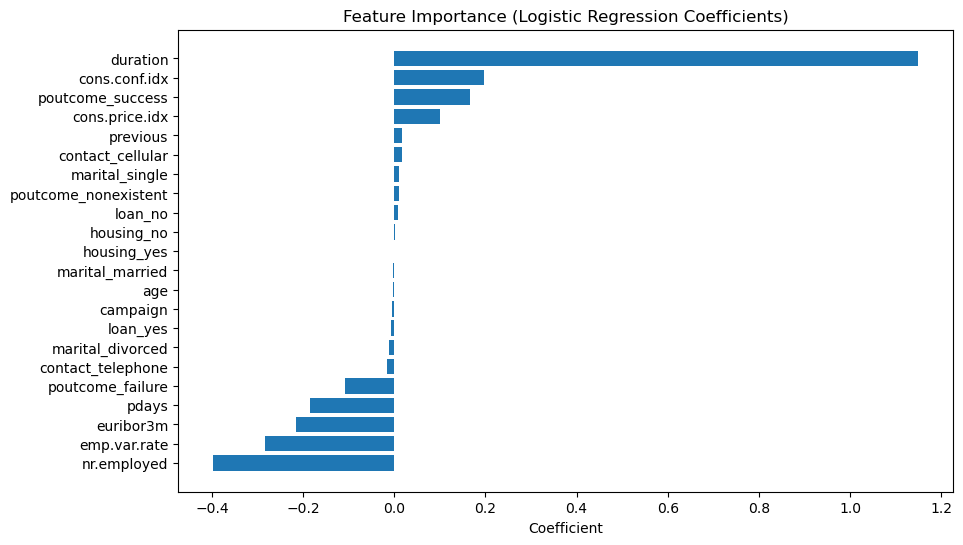

In [177]:
#Retrieve coefficients from logistic regression
importance = logreg_grid1.best_estimator_.named_steps['logreg'].coef_[0]

# Get feature names
feature_names = X_train.columns.to_list()

# Create a DataFrame to visualize
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importance[1:]})

# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance = importance_df[~importance_df['Feature'].str.startswith(('month', 'day', 'job', 'education'))]
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'])
plt.xlabel('Coefficient')
plt.title('Feature Importance (Logistic Regression Coefficients)')
plt.show()

#### Day of the week importance

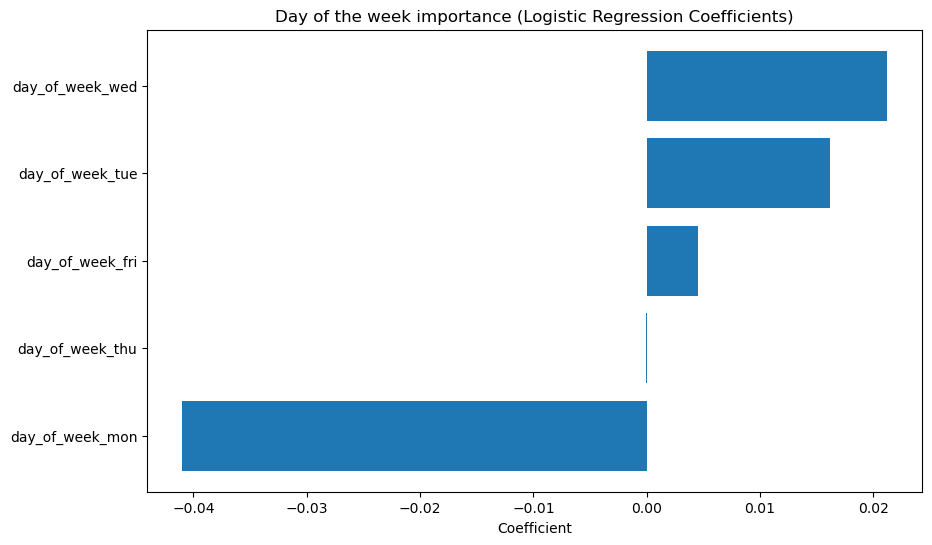

In [117]:
# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance = importance_df[importance_df['Feature'].str.startswith(('day'))]
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'])
plt.xlabel('Coefficient')
plt.title('Day of the week importance (Logistic Regression Coefficients)')
plt.show()

#### Month importance

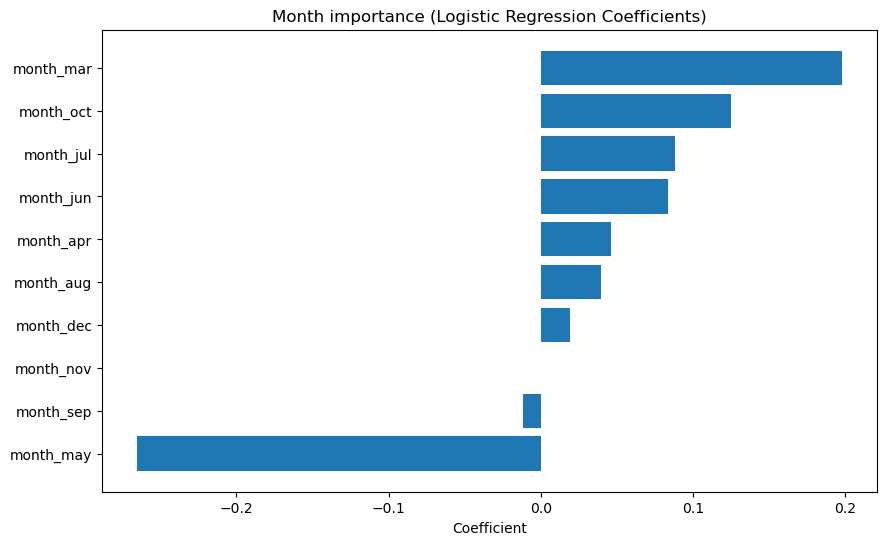

In [120]:
# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance = importance_df[importance_df['Feature'].str.startswith(('month'))]
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'])
plt.xlabel('Coefficient')
plt.title('Month importance (Logistic Regression Coefficients)')
plt.show()

#### Education importance

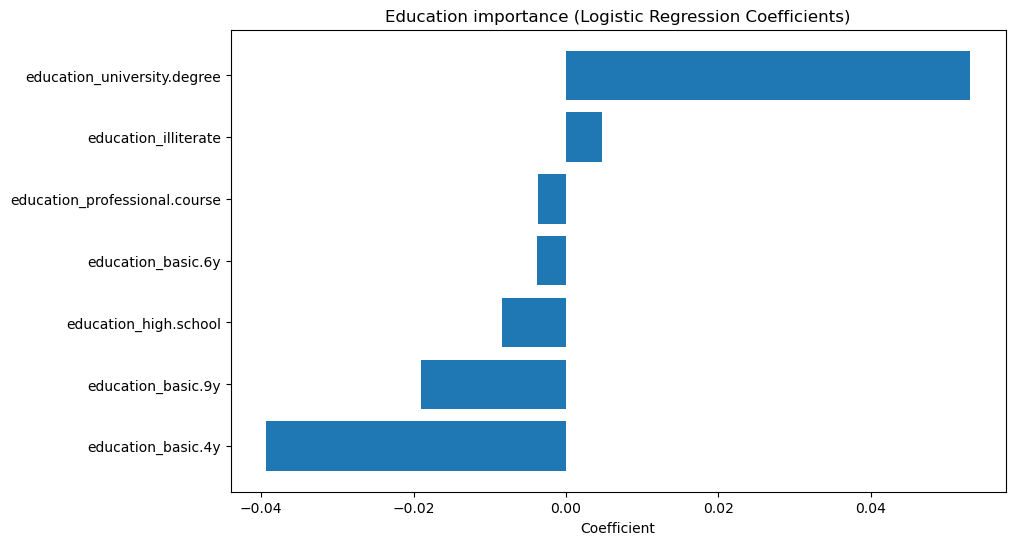

In [123]:
# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance = importance_df[importance_df['Feature'].str.startswith(('education'))]
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'])
plt.xlabel('Coefficient')
plt.title('Education importance (Logistic Regression Coefficients)')
plt.show()

#### Job importance

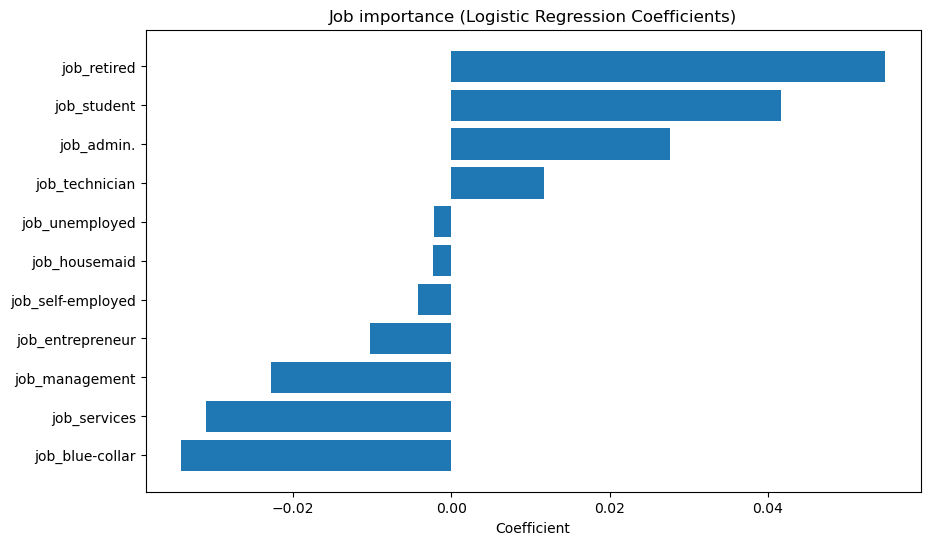

In [126]:
# Sort the features by importance
importance_df = importance_df.sort_values(by='Importance', ascending=True)
importance = importance_df[importance_df['Feature'].str.startswith(('job'))]
# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'])
plt.xlabel('Coefficient')
plt.title('Job importance (Logistic Regression Coefficients)')
plt.show()

# Conclusions:

    1.The best predictive model, as measured by ROC AUC, was achieved with Logistic Regression (ROC AUC = 0.94), followed by SVM (ROC AUC = 0.93), Decision Tree (ROC AUC = 0.92), and KNN (ROC AUC = 0.91). Furthermore, KNN classifier appeared to have trouble achiving high recall score making it the least favorable. 
    2.For the best model (Logistic Regression), at recall = 0.98, we achieved precision = 0.32, meaning we can identify most customers, considering that baseline acceptance rate was 0.12, at precision of 0.32, we can perform 2.6 times fewer calls to achieve nearly the same results.  
    3.I attempted balancing the training dataset using the Synthetic Minority Oversampling Technique (SMOTE), which appeared to improve the Decision Tree classifier. Other models did not benefit from data balancing.
    4.Based on Logistic Regression coefficients, the most important features were: employment variation rate (negative correlation), Euribor 3-month rate (positive correlation), consumer price index (positive correlation), last contact duration (positive correlation), previous outreach success (positive correlation), number of employees (negative correlation), and the number of days since the client was last contacted from a previous campaign (negative correlation).
    5.It should be noted that last contact duration is strongly associated with success, but it may not be a valuable predictive parameter.
    6.Macroeconomic features like the Euribor 3-month rate, employment, and consumer sentiment, while strongly predictive, may not be useful for customer stratification as they are common for all customers at a given date.
    7.The level of customer education had a weak effect, with higher education being positively correlated.
    8.Customers’ jobs had a weak effect, with being retired or a student positively correlated, and blue-collar and service jobs negatively correlated.
    9.The day of the week had a weak effect, with Monday being less preferred.
    10.The month of contact had a weak effect, with May being less preferred. However, there is no clear explanation, as neighboring months (April and June) do not follow the same trend, indicating it might be a serendipitous correlation.
    11.Many features had negligible effects on success, including housing loan, marital status, personal loan, contact communication type, and the number of contacts during and before the campaign.
    12.Considering the negligible effect of multiple contacts, it might be beneficial to cap the number of times a person is contacted during a single campaign, as more frequent contacts do not translate into higher success. Perhaps contacting people more sporadically across multiple campaigns would lead to better results. In the current campaign on average 2.6 calls have been performed per customer, whereas it seems that a single call would have simillar effect. 

# Next steps and recommendations:

    1.I would recommend building the model without macroeconomic features as they are common for all customers. While they are informative for general predictions of success, they do not help in stratifying customers who are most likely to sign a deal.
    2.For customer stratification, I would also refrain from using call duration as it does not seem to be known ahead of time.
    3.The clients are highly sensitive to macroeconomic indicators, suggesting that personal finances might influence their decision on when to open a long-term deposit. It might be beneficial to augment data collection for future campaigns with other information related to the customer’s economic situation, such as income, credit score, age of their car, whether they have children, etc. This could help create a much more predictive model for identifying customers' willingness to open long-term deposits.